# Overview

Airbnb, a popular platform for sharing rooms, has made a big impact on where people stay when they travel. With over three million listings worldwide, Airbnb offers a wide variety of places to stay, each with its own style, amenities, and location. Guests have their own preferences, but some amenities always seem to make them happy, as shown by their positive reviews and ratings.

Both guests and hosts are important for Airbnb's success. Guests want a great experience, aiming for a five-star stay with amenities that make them happy. Hosts want to attract as many guests as possible, so they often focus on offering the top 10 amenities that guests look for.

For hosts to be successful on Airbnb, they need to consider many factors. New hosts may need advice on making their properties attractive, while existing hosts might wonder why they're not getting high ratings. Our goal as consultants is to help both new and experienced hosts understand how to get top ratings and become Superhosts.

# Goal
* To analyze Airbnb data in Los Angeles, comparing superhosts and standard hosts.
* To develop a content-based recommendation system for Airbnbs in Los Angeles.
* Identify key amenities associated with superhost status.
* Determine the most impactful amenities for achieving and maintaining superhost status in the Los Angeles Airbnb market.

# Importing Rrequired Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import time
import re
import pickle

import reverse_geocoder as rg

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

import warnings
warnings.filterwarnings('ignore')

C:\Users\zaida\Downloads\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Frames

In [2]:
reviews = pd.read_csv(r"C:\Users\zaida\Downloads\airbnb Los Angeles\reviews.csv")

In [3]:
listing = pd.read_csv(r"C:\Users\zaida\Downloads\airbnb Los Angeles\listings.csv")

In [4]:
# Shape of the dataframe
print('reviews = ',reviews.shape)
print('listing = ',listing.shape)

reviews =  (1528123, 6)
listing =  (45591, 75)


In [5]:
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0         109    449036  2011-08-15       927861         Edwin   
1         109  74506539  2016-05-15     22509885          Jenn   
2        2708  13994902  2014-06-09     10905424       Kuberan   
3        2708  14606598  2014-06-23      2247288       Camilla   
4        2708  39597339  2015-07-25     27974696        Fallon   

                                            comments  
0  The host canceled my reservation the day befor...  
1  Me and two friends stayed for four and a half ...  
2  i had a wonderful stay. Everything from start ...  
3  Charles is just amazing and he made my stay sp...  
4  Staying with Chas was an absolute pleasure. He...

In [6]:
listing.head(2)

id                        listing_url       scrape_id last_scraped  \
0   109   https://www.airbnb.com/rooms/109  20231203160142   2023-12-05   
1  2708  https://www.airbnb.com/rooms/2708  20231203160142   2023-12-04   

        source                                               name  \
0  city scrape  Condo in Culver City · 2 bedrooms · 2 beds · 2...   
1  city scrape  Rental unit in Los Angeles · ★4.85 · 1 bedroom...   

   description                              neighborhood_overview  \
0          NaN                                                NaN   
1          NaN  Walk and run to Runyon Canyon, it is open!<br ...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/miso/Hosting-...      521  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...     3008  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.00                   5.00                4.00   
1                        4.98                   4.95                4.88   

  license instant_bookable calculated_host_listings_count  \
0     NaN                f                              1   
1     NaN                t                              2   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            2   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.01  
1                                           0              0.35  

[2 rows x 75 columns]

### Data Structure

In [7]:
# Listing
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45591 non-null  int64  
 1   listing_url                                   45591 non-null  object 
 2   scrape_id                                     45591 non-null  int64  
 3   last_scraped                                  45591 non-null  object 
 4   source                                        45591 non-null  object 
 5   name                                          45591 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         25200 non-null  object 
 8   picture_url                                   45591 non-null  object 
 9   host_id                                       45591 non-null 

 Listing dataframe contains 75 columns 45592 rows

#### "We're selecting columns that are important or can help in building this model."

In [8]:
# Based on our requirnment i am selecting features.

imp_columns = ['id', 'listing_url', 'host_url', 'last_scraped', 'name', 
                 'neighborhood_overview', 'host_since', 'neighbourhood_cleansed', 
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
                 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
                 'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                 'review_scores_location', 'instant_bookable', 'calculated_host_listings_count'
                 ]

# subsetting a dataframe of the relevant columns
listing = listing[imp_columns]

In [9]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              45591 non-null  int64  
 1   listing_url                     45591 non-null  object 
 2   host_url                        45591 non-null  object 
 3   last_scraped                    45591 non-null  object 
 4   name                            45591 non-null  object 
 5   neighborhood_overview           25200 non-null  object 
 6   host_since                      45575 non-null  object 
 7   neighbourhood_cleansed          45591 non-null  object 
 8   host_response_time              34863 non-null  object 
 9   host_response_rate              34863 non-null  object 
 10  host_acceptance_rate            35953 non-null  object 
 11  host_is_superhost               45342 non-null  object 
 12  latitude                        

In [10]:
# Reviews
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528123 entries, 0 to 1528122
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1528123 non-null  int64 
 1   id             1528123 non-null  int64 
 2   date           1528123 non-null  object
 3   reviewer_id    1528123 non-null  int64 
 4   reviewer_name  1528121 non-null  object
 5   comments       1527771 non-null  object
dtypes: int64(3), object(3)
memory usage: 70.0+ MB


reviews contains 6 columns and 15 lakh 28 thousand 1 hundred 23 rows

In [11]:
reviews.describe()

listing_id            id   reviewer_id
count  1.528123e+06  1.528123e+06  1.528123e+06
mean   1.038964e+17  3.773624e+17  1.565547e+08
std    2.594801e+17  3.992465e+17  1.460681e+08
min    1.090000e+02  3.197000e+03  2.000000e+00
25%    1.227277e+07  4.107812e+08  3.407052e+07
50%    2.488675e+07  3.862321e+17  1.093503e+08
75%    4.662927e+07  7.697389e+17  2.446418e+08
max    1.036603e+18  1.039358e+18  5.492742e+08

# Preprocessing

## Missing values

In [12]:
listing.isna().sum()

id                                    0
listing_url                           0
host_url                              0
last_scraped                          0
name                                  0
neighborhood_overview             20391
host_since                           16
neighbourhood_cleansed                0
host_response_time                10728
host_response_rate                10728
host_acceptance_rate               9638
host_is_superhost                   249
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms_text                       35
bedrooms                          45488
beds                                477
amenities                             0
price                                 0
number_of_reviews                     0
review_scores_rating              12628
review_scores_accuracy            12640


In [13]:
# Lets fill the missing values

#### neighborhood_overview column

In [14]:
# Neighborhood conrtains information about neighborhood
listing.neighborhood_overview

0                                                      NaN
1        Walk and run to Runyon Canyon, it is open!<br ...
2        This is the best part of Santa Monica. Quiet, ...
3        What makes the neighborhood unique is that the...
4                                                      NaN
                               ...                        
45586                                                  NaN
45587                                                  NaN
45588                                                  NaN
45589                                                  NaN
45590                                                  NaN
Name: neighborhood_overview, Length: 45591, dtype: object

In [15]:
# i filled this column with empty string
listing['neighborhood_overview'] = listing.neighborhood_overview.fillna('')

listing.neighborhood_overview.isna().sum()

0

#### Host columns

 We have 5 host columns who are containing missing values

1) host_since : The date the host/user was created. For hosts that are Airbnb guests this could be the date they registered as a guest

In [16]:
# Host since column containing dates, Here i am filling missing values with most frequent date
listing['host_since'] = listing.host_since.fillna(listing.host_since.mode()[0])

listing.host_since.isna().sum()

0

 2) host_responce_time : How much time host take to responds

In [17]:
listing.host_response_time.unique()

array([nan, 'within an hour', 'within a few hours', 'within a day',
       'a few days or more'], dtype=object)

In [18]:
# Here i wil fill host_responce_time with 'unknown'
listing['host_response_time'] = listing.host_response_time.fillna('Unknown')

3) * host_responce_rate:(The rate at which the host responds when called upon) and
4)  * host_acceptance_rate : (That rate at which a host accepts booking requests)

In [19]:
listing.host_response_rate.unique()

array([nan, '100%', '83%', '90%', '93%', '0%', '75%', '71%', '91%', '33%',
       '63%', '25%', '70%', '67%', '82%', '80%', '50%', '96%', '98%',
       '97%', '89%', '86%', '40%', '17%', '20%', '95%', '36%', '99%',
       '14%', '92%', '30%', '94%', '85%', '60%', '88%', '10%', '69%',
       '9%', '78%', '57%', '11%', '73%', '43%', '79%', '22%', '77%',
       '81%', '26%', '13%', '56%', '74%', '87%', '29%', '44%', '65%',
       '76%', '55%', '84%', '64%', '72%', '62%', '47%', '18%', '19%',
       '24%', '39%', '8%', '38%', '48%'], dtype=object)

In [20]:
listing.host_acceptance_rate.unique()

array(['50%', '100%', '42%', nan, '96%', '79%', '95%', '85%', '84%',
       '97%', '88%', '75%', '98%', '86%', '67%', '80%', '33%', '99%',
       '77%', '69%', '53%', '94%', '63%', '89%', '0%', '74%', '62%',
       '20%', '14%', '91%', '82%', '93%', '87%', '76%', '72%', '90%',
       '25%', '73%', '83%', '78%', '92%', '66%', '40%', '37%', '81%',
       '38%', '13%', '71%', '57%', '68%', '23%', '54%', '47%', '43%',
       '70%', '11%', '55%', '65%', '5%', '7%', '2%', '64%', '60%', '52%',
       '39%', '59%', '16%', '56%', '61%', '58%', '36%', '18%', '17%',
       '29%', '35%', '49%', '9%', '46%', '3%', '19%', '44%', '8%', '45%',
       '51%', '15%', '26%', '48%', '31%', '27%', '30%', '34%', '22%',
       '10%', '41%', '32%', '12%', '24%', '4%', '1%'], dtype=object)

In [21]:
# In python, the strip() function is used to remove whitespaces,special charecters etc from a string.
# Stripping % signs from 'host_response_rate' and 'host_acceptance_rate' columns

listing['host_response_rate'] = listing['host_response_rate'].str.rstrip('%')
listing['host_acceptance_rate'] = listing['host_acceptance_rate'].str.rstrip('%')

In [22]:
# Changing Datatype
listing["host_response_rate"] = listing["host_response_rate"].astype(float)

In [23]:
# filling missing values with median
listing['host_response_rate'].fillna(value=listing['host_response_rate'].median(), inplace=True)

In [24]:
# host_acceptance_rate:
# Changing Datatype
listing["host_acceptance_rate"] = listing["host_acceptance_rate"].astype(float)

In [25]:
# filling missing values with median
listing['host_acceptance_rate'].fillna(value=listing['host_acceptance_rate'].median(), inplace=True)

5) host_is_superhost : Whether the host has a superhost rating or not

In [26]:
listing.host_is_superhost.unique()

array(['f', 't', nan], dtype=object)

 We need to change the way we represent whether a host is a superhost or not, so it's easier to understand if they are or aren't. We'll change it to a simpler format that shows if a host is a superhost or not using just two categories, like "Yes" for superhost and "No" for non-superhost.

In [27]:
# repacing values to make column a bool dtype
# In this 0 representing host is not a superhost and 1 is representing host is superhost

listing['host_is_superhost'] = listing['host_is_superhost'].replace({'t': 1, 'f': 0})

In [28]:
listing['host_is_superhost'].isna().sum()

249

In [29]:
# Lets fill these nans with mode
listing['host_is_superhost'] = listing['host_is_superhost'].fillna(listing['host_is_superhost'].mode()[0])

listing.host_is_superhost.isna().sum()

0

#### Bathroom Text
The number of bathrooms in the listing.

In [30]:
listing.bathrooms_text.unique()

array(['2 baths', '1 shared bath', '1 private bath', '1 bath', '3 baths',
       '1.5 shared baths', '1.5 baths', '3.5 baths', '2.5 baths',
       '11 shared baths', '2 shared baths', '0 baths', nan, '4.5 baths',
       '8 shared baths', '8 baths', '8.5 shared baths',
       '2.5 shared baths', 'Private half-bath', '3.5 shared baths',
       'Half-bath', '4 baths', '5 baths', '3 shared baths',
       '11.5 shared baths', '7.5 baths', '0 shared baths', '5.5 baths',
       'Shared half-bath', '6.5 baths', '11 baths', '6 baths', '7 baths',
       '4 shared baths', '8.5 baths', '12.5 baths', '10 baths',
       '9.5 baths', '9 baths', '12 baths', '10.5 baths',
       '4.5 shared baths', '11.5 baths', '13 baths', '5.5 shared baths',
       '13.5 baths', '24 baths', '21 baths', '15 baths', '5 shared baths',
       '10 shared baths', '6 shared baths', '14 shared baths', '17 baths',
       '27 baths', '36 baths', '25 baths', '7 shared baths',
       '13 shared baths'], dtype=object)

In [31]:
# strip the records to remain with the numerical value strings
listing['bathrooms_text'] = listing['bathrooms_text'].str.extract('(\d+\.?\d*)')
# changing column to float
listing['bathrooms_text'] = listing['bathrooms_text'].astype('float')

In [32]:
# fill missing values with median
listing['bathrooms_text'].fillna(value=listing['bathrooms_text'].median(), inplace=True) 

In [33]:
# changing column name 
listing.rename(columns={'bathrooms_text': 'num_of_bathrooms'}, inplace=True)

In [34]:
listing.num_of_bathrooms.unique()

array([ 2. ,  1. ,  3. ,  1.5,  3.5,  2.5, 11. ,  0. ,  4.5,  8. ,  8.5,
        4. ,  5. , 11.5,  7.5,  5.5,  6.5,  6. ,  7. , 12.5, 10. ,  9.5,
        9. , 12. , 10.5, 13. , 13.5, 24. , 21. , 15. , 14. , 17. , 27. ,
       36. , 25. ])

#### Bedroom Column
It store number of bedrooms

In [35]:
listing.bedrooms.unique()

array([nan,  2.,  4.,  6.,  5.,  8.,  3.,  9.,  7.])

In [36]:
listing.bedrooms.describe()

count    103.000000
mean       4.932039
std        1.535604
min        2.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        9.000000
Name: bedrooms, dtype: float64

In [37]:
# Filling missing values with the median
listing['bedrooms'] = listing.bedrooms.fillna(listing.bedrooms.median())

#### beds column 
Number of beds present in perticular airbnb

In [38]:
listing.beds.unique()

array([ 2.,  1.,  3.,  5.,  4., 10., nan,  9.,  6.,  7.,  8., 19., 16.,
       12., 14., 11., 15., 17., 18., 13., 20., 24., 32., 25., 21., 50.,
       30.])

In [39]:
listing.beds.describe()

count    45114.000000
mean         2.204571
std          1.700863
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         50.000000
Name: beds, dtype: float64

<Axes: >

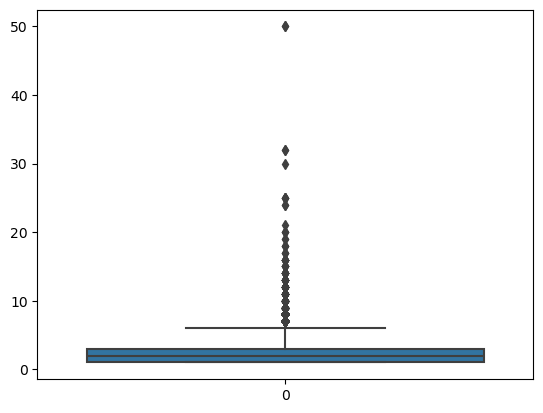

In [40]:
sns.boxplot(listing['beds'])

<Axes: xlabel='beds', ylabel='Density'>

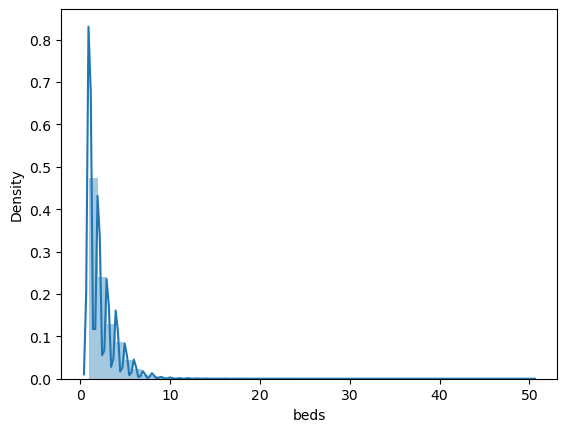

In [41]:
sns.distplot(listing['beds'])

In [42]:
# Here my data is skewed and contains Outliers so i decided to remove outliers with the help of IQR

In [43]:
q1=listing['beds'].quantile(0.25)
q3=listing['beds'].quantile(0.75)

iqr=q3-q1

upper = q3+1.5*iqr
lower = q1-1.5*iqr

listing['beds']=listing['beds'].map(lambda x : upper if x>upper else lower if x<lower else x)

In [44]:
# Filling missing values with median
listing['beds'] = listing.beds.fillna(listing.beds.median())

#### Review Score Columns

In [45]:
# There are 5 Review scores columns and all are numericc

In [46]:
reviews_col = ['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location']

In [47]:
listing[reviews_col].head(2)

review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.00                     5.0                       5.00   
1                  4.85                     4.8                       4.93   

   review_scores_checkin  review_scores_communication  review_scores_location  
0                    3.0                         4.00                    5.00  
1                    5.0                         4.98                    4.95

In [48]:
listing[reviews_col].describe()

review_scores_rating  review_scores_accuracy  \
count          32963.000000            32951.000000   
mean               4.749334                4.775100   
std                0.484295                0.467778   
min                0.000000                0.000000   
25%                4.710000                4.750000   
50%                4.890000                4.920000   
75%                5.000000                5.000000   
max                5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               32950.000000           32943.000000   
mean                    4.717921               4.839475   
std                     0.500457               0.416244   
min                     0.000000               0.000000   
25%                     4.670000               4.850000   
50%                     4.880000               4.970000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  
count                 32950.000000            32941.000000  
mean                      4.835456                4.780406  
std                       0.434832                0.417769  
min                       0.000000                0.000000  
25%                       4.860000                4.740000  
50%                       4.970000                4.900000  
75%                       5.000000                5.000000  
max                       5.000000                5.000000

In [49]:
# imputing missing values with median
listing[reviews_col] = listing[reviews_col].fillna(listing[reviews_col].median())

In [50]:
# rounding off ratings values 
listing[reviews_col] = listing[reviews_col].round(0)

Now you can check there is no missing values in any column

In [51]:
listing.isna().sum()

id                                0
listing_url                       0
host_url                          0
last_scraped                      0
name                              0
neighborhood_overview             0
host_since                        0
neighbourhood_cleansed            0
host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
num_of_bathrooms                  0
bedrooms                          0
beds                              0
amenities                         0
price                             0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication 

### Checking for Duplicates

In [52]:
listing.duplicated().sum()

0

### Cleaning others features

In [53]:
listing.head(2)

id                        listing_url  \
0   109   https://www.airbnb.com/rooms/109   
1  2708  https://www.airbnb.com/rooms/2708   

                                 host_url last_scraped  \
0   https://www.airbnb.com/users/show/521   2023-12-05   
1  https://www.airbnb.com/users/show/3008   2023-12-04   

                                                name  \
0  Condo in Culver City · 2 bedrooms · 2 beds · 2...   
1  Rental unit in Los Angeles · ★4.85 · 1 bedroom...   

                               neighborhood_overview  host_since  \
0                                                     2008-06-27   
1  Walk and run to Runyon Canyon, it is open!<br ...  2008-09-16   

  neighbourhood_cleansed host_response_time  host_response_rate  ...    price  \
0            Culver City            Unknown               100.0  ...  $129.00   
1              Hollywood            Unknown               100.0  ...   $94.00   

   number_of_reviews  review_scores_rating  review_scores_accuracy  \
0                  2                   4.0                     5.0   
1                 40                   5.0                     5.0   

  review_scores_cleanliness review_scores_checkin  \
0                       5.0                   3.0   
1                       5.0                   5.0   

   review_scores_communication  review_scores_location  instant_bookable  \
0                          4.0                     5.0                 f   
1                          5.0                     5.0                 t   

   calculated_host_listings_count  
0                               1  
1                               2  

[2 rows x 31 columns]

#### instant_bookable
This feature represent a guest can automatically book a house without the host require to accept his/her request.

In [54]:
# Instant bookable column contains values(f/t) now we have to convert this values into 0/1
listing.instant_bookable.unique()

array(['f', 't'], dtype=object)

In [55]:
# Converting these (f/t) to (0/1) 
listing['instant_bookable'] = listing.instant_bookable.replace({'t':1,'f':0})

In [56]:
listing.instant_bookable.unique()

array([0, 1], dtype=int64)

#### price column
Price column represent a price in dollars

In [57]:
listing.price.unique()

array(['$129.00', '$94.00', '$179.00', ..., '$837.00', '$2,393.00',
       '$936.00'], dtype=object)

In [58]:
# So here there is an $ sign which we have to remove
listing.price = listing.price.replace('[\$,]', '', regex=True).astype(float)

In [59]:
listing.price.unique()

array([ 129.,   94.,  179., ...,  837., 2393.,  936.])

#### amenities 
Basic items the guests gets in the airbnb that helps to make them comfortable

In [60]:
listing.amenities

0        ["Private patio or balcony", "Shared pool", "E...
1        ["Wen, V05, Prell, among others.  conditioner"...
2        ["Private patio or balcony", "Hair dryer", "De...
3        ["TV", "Iron", "Essentials", "Carbon monoxide ...
4        ["Shampoo", "Kitchen", "Hot water kettle", "Ir...
                               ...                        
45586    ["TV", "Carbon monoxide alarm", "Dedicated wor...
45587    ["TV", "Pool", "Air conditioning", "Kitchen", ...
45588    ["TV", "Elevator", "Paid parking on premises",...
45589    ["TV", "Dedicated workspace", "Kitchen", "Wifi...
45590    ["TV", "Paid parking on premises", "Kitchen", ...
Name: amenities, Length: 45591, dtype: object

In [62]:
# creating a list of lower and uppercase letters 
letters = string.ascii_letters

# splitting each record to extract the amenities
amenities_split = listing['amenities'].apply(lambda x: x.split('"'))

new_amenities = []

# making a list of lists 
for split in amenities_split:
    res = [x for x in split if x[0] in letters]
    new_amenities.append(res)

# replacing amenities with the list of lists
listing['amenities'] = new_amenities

# engineering a new column that is the count of amenities per record
listing['amenities_count'] = listing['amenities'].apply(lambda x: len(x))

# checking unique counts
listing['amenities_count'].nunique()

110

In [63]:
# viewing the top 6 number of amenities in a listing
listing['amenities_count'].sort_values(ascending=False).head(6)

36933    119
30783    111
9875     110
15897    110
23824    108
22637    108
Name: amenities_count, dtype: int64

In [64]:
# checking a row that has amenities_count greater than 70
listing[listing['amenities_count'] > 70]['amenities'][118]

['Private patio or balcony',
 'Shampoo',
 'Kitchen',
 'Laundromat nearby',
 'Cleaning available during stay',
 'Hot water kettle',
 'Single level home',
 'Iron',
 'Coffee',
 'Children\\u2019s dinnerware',
 'Essentials',
 'Carbon monoxide alarm',
 'Free dryer \\u2013 In unit',
 'Coffee maker',
 'EV charger',
 'Books and reading material',
 'Portable fans',
 'Shower gel',
 'First aid kit',
 'Wifi',
 'Drying rack for clothing',
 'Heating',
 'Wine glasses',
 'Free parking on premises',
 'Long term stays allowed',
 'Window AC unit',
 'Free washer \\u2013 In unit',
 'Luggage dropoff allowed',
 'Conditioner',
 'Cleaning products',
 'Clothing storage: walk-in closet, closet, and dresser',
 'Cooking basics',
 'Toaster',
 'Outdoor furniture',
 'Hot water',
 'Beach access',
 'Dining table',
 'Mountain view',
 'Bed linens',
 'Ceiling fan',
 'Fire extinguisher',
 'Pocket wifi',
 'Freezer',
 'Oven',
 'Host greets you',
 'Theme room',
 'Mini fridge',
 'BBQ grill',
 'Courtyard view',
 'Room-darkening 

#### Last_scrap column
The date and time this listing was "scraped"

In [65]:
# viewing 'scrape' columns

listing['last_scraped'].head(2) 

0    2023-12-05
1    2023-12-04
Name: last_scraped, dtype: object

#### hosting duration column

 lets find the hosting duration of the host with the help of last scrap and host since

In [66]:
# Extracting the year from last scrap
listing['last_scraped'] = listing['last_scraped'].apply(lambda x: x[:4])
# With the help of lambda function i extracted year

In [67]:
# Extracting the year from host_since
listing['host_since'] = listing['host_since'].apply(lambda x: x[:4])


In [68]:
# changing column data type
listing['last_scraped'] = listing['last_scraped'].astype(int) 
listing['host_since'] = listing['host_since'].astype(int) 

In [69]:
# creating a new column to show age of the host
listing['hosting_duration'] = listing['last_scraped'] - listing['host_since']

In [70]:
# dropping last_scrapped and host_since columns
listing.drop(columns= ['last_scraped', 'host_since'], inplace= True) 

 Now data cleaning part is over

In [71]:
listing.head(2)

id                        listing_url  \
0   109   https://www.airbnb.com/rooms/109   
1  2708  https://www.airbnb.com/rooms/2708   

                                 host_url  \
0   https://www.airbnb.com/users/show/521   
1  https://www.airbnb.com/users/show/3008   

                                                name  \
0  Condo in Culver City · 2 bedrooms · 2 beds · 2...   
1  Rental unit in Los Angeles · ★4.85 · 1 bedroom...   

                               neighborhood_overview neighbourhood_cleansed  \
0                                                               Culver City   
1  Walk and run to Runyon Canyon, it is open!<br ...              Hollywood   

  host_response_time  host_response_rate  host_acceptance_rate  \
0            Unknown               100.0                  50.0   
1            Unknown               100.0                 100.0   

   host_is_superhost  ...  review_scores_rating  review_scores_accuracy  \
0                0.0  ...                   4.0                     5.0   
1                1.0  ...                   5.0                     5.0   

  review_scores_cleanliness review_scores_checkin  \
0                       5.0                   3.0   
1                       5.0                   5.0   

   review_scores_communication  review_scores_location  instant_bookable  \
0                          4.0                     5.0                 0   
1                          5.0                     5.0                 1   

   calculated_host_listings_count amenities_count  hosting_duration  
0                               1              30                15  
1                               2              67                15  

[2 rows x 31 columns]

# EDA

First lets find the categorical variables

In [72]:
# categorical variables 
categorical_var = ['host_response_time', 'host_response_rate','host_acceptance_rate', 'host_is_superhost', 'room_type',
                    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'hosting_duration', 'review_scores_rating', 
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'instant_bookable', 'calculated_host_listings_count', 'amenities_count']
                        

### binning categorical variables

 function to bin host response rate and acceptance rate


In [73]:
def bin_column(dataframe, column, new_col):
    bins = [0, 50, 70, 90, 100]  # Adjusted the bins slightly to include 90 for better accuracy
    labels = ['0-50', '51-70', '71-89', '90-100']  # Adjusted the label accordingly
    dataframe[new_col] = pd.cut(dataframe[column], bins=bins, labels=labels)

    return dataframe.head(1)  # Returning the first row of the modified DataFrame



In [74]:
#host response rate
bin_column(listing,'host_response_rate','response_rate')

# host_acceptance rate
bin_column(listing,'host_acceptance_rate','acceptance_rate')

id                       listing_url  \
0  109  https://www.airbnb.com/rooms/109   

                                host_url  \
0  https://www.airbnb.com/users/show/521   

                                                name neighborhood_overview  \
0  Condo in Culver City · 2 bedrooms · 2 beds · 2...                         

  neighbourhood_cleansed host_response_time  host_response_rate  \
0            Culver City            Unknown               100.0   

   host_acceptance_rate  host_is_superhost  ...  review_scores_cleanliness  \
0                  50.0                0.0  ...                        5.0   

   review_scores_checkin review_scores_communication review_scores_location  \
0                    3.0                         4.0                    5.0   

   instant_bookable  calculated_host_listings_count  amenities_count  \
0                 0                               1               30   

   hosting_duration response_rate  acceptance_rate  
0                15        90-100             0-50  

[1 rows x 33 columns]

### accomodates, beds, bedrooms, bathrooms column

lets check correlation between these columns

In [75]:
# correlation
listing[['accommodates','beds','bedrooms','num_of_bathrooms']].corr()

accommodates      beds  bedrooms  num_of_bathrooms
accommodates          1.000000  0.858223  0.042981          0.669086
beds                  0.858223  1.000000  0.027475          0.638372
bedrooms              0.042981  0.027475  1.000000          0.074939
num_of_bathrooms      0.669086  0.638372  0.074939          1.000000

<Axes: >

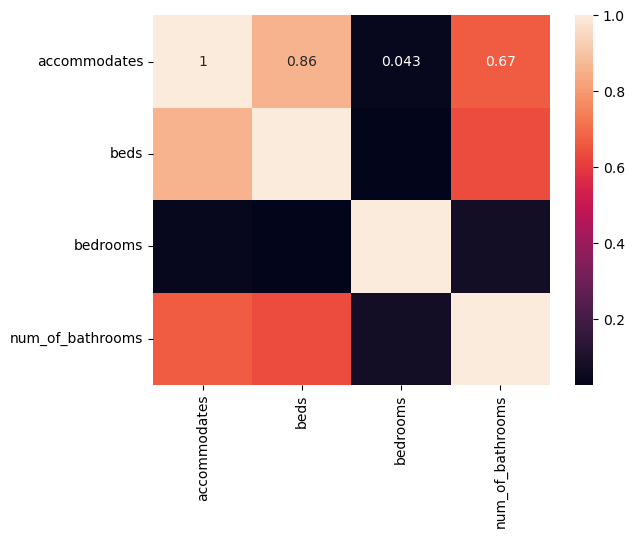

In [76]:
sns.heatmap(listing[['accommodates','beds','bedrooms','num_of_bathrooms']].corr(),annot=True)

In [77]:
# As you can see there is an strong correlation between (accomodates, beds, num_of_bathrooms).
# We can select one column from these three column here i am taking accommodates column.

In [78]:
# binning the accommodates column
bins = [0, 4, 8, 12, 16]
labels = ['1-4 people', '5-8 people', '9-12 people', 'above 12 people']
listing['accommodate'] = pd.cut(listing['accommodates'], bins=bins, labels=labels)

#### Number of amenities

In [79]:
# binning amenities_count 
bins = [0, 10, 20, 30, 100]
labels = ['0-10', '11-20', '21-30', 'above 30']
listing['amenities_binned'] = pd.cut(listing['amenities_count'], bins=bins, labels=labels)
# Pd.cut: used for binning of continous variables

Lets check which is the most common ammenities in this high rated airbnbs?

In [80]:
# listings with overall rating of 5
high_rating = listing[listing.review_scores_rating == 5]


In [81]:
# function to turn a 2D list into 1D
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [82]:
#get the value_counts
common_amenities = to_1D(high_rating['amenities']).value_counts()
# top 30 amenities
top_30 = common_amenities[:30]

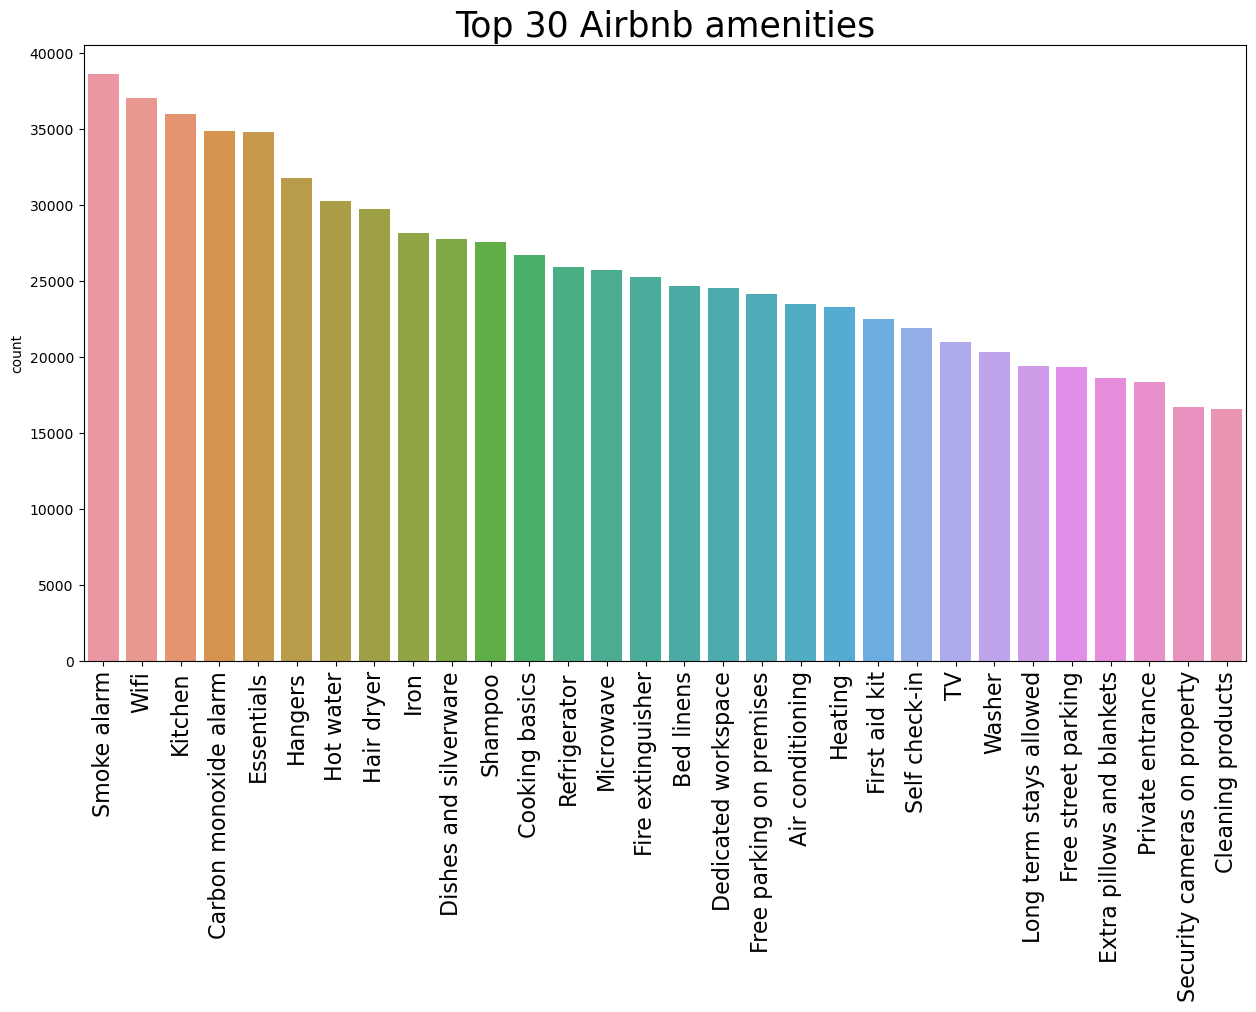

In [83]:
# barplot of amenity counts in high rated listings
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = top_30.index, y = top_30)
ax.set_title('Top 30 Airbnb amenities', fontsize=25)
plt.xticks(rotation = 90, fontsize=16);

### Observation
Highly-rated Airbnbs provide things like Smoke Alarm, WiFi which lets guests stay connected, and they allow people to stay for longer periods. They usually have a kitchen with everything you need to cook (like dishes and pots), a fridge, and they provide essentials like toilet paper and soap. They also have handy things like hangers for clothes and an iron to keep clothes neat. Overall, they offer a really comfortable stay, based on the top 30 amenities people like.






### Handling missing values of newly added columns

In [84]:
listing.isna().sum()

id                                  0
listing_url                         0
host_url                            0
name                                0
neighborhood_overview               0
neighbourhood_cleansed              0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                   0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
num_of_bathrooms                    0
bedrooms                            0
beds                                0
amenities                           0
price                               0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_scores_cleanliness           0
review_scores_checkin               0
review_scores_communication         0
review_score

#### response rate

In [85]:
listing.response_rate.unique()

['90-100', '71-89', NaN, '0-50', '51-70']
Categories (4, object): ['0-50' < '51-70' < '71-89' < '90-100']

In [86]:
# I am using mode for filling missing values
listing['response_rate'] = listing.response_rate.fillna(listing.response_rate.mode()[0])

#### acceptance rate

In [87]:
listing.acceptance_rate.unique()

['0-50', '90-100', '71-89', '51-70', NaN]
Categories (4, object): ['0-50' < '51-70' < '71-89' < '90-100']

In [88]:
# I am using mode for filling missing values
listing['acceptance_rate'] = listing.acceptance_rate.fillna(listing.acceptance_rate.mode()[0])

#### ammenities binned

In [89]:
listing.amenities_binned.unique()

['21-30', 'above 30', '11-20', '0-10', NaN]
Categories (4, object): ['0-10' < '11-20' < '21-30' < 'above 30']

In [90]:
# I am using mode for filling missing values
listing['amenities_binned'] = listing.amenities_binned.fillna(listing.amenities_binned.mode()[0])

In [91]:
listing.isna().sum()

id                                0
listing_url                       0
host_url                          0
name                              0
neighborhood_overview             0
neighbourhood_cleansed            0
host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
num_of_bathrooms                  0
bedrooms                          0
beds                              0
amenities                         0
price                             0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
instant_bookable            

## property type

Here we are trying to find which is the most commmon and preferable property type

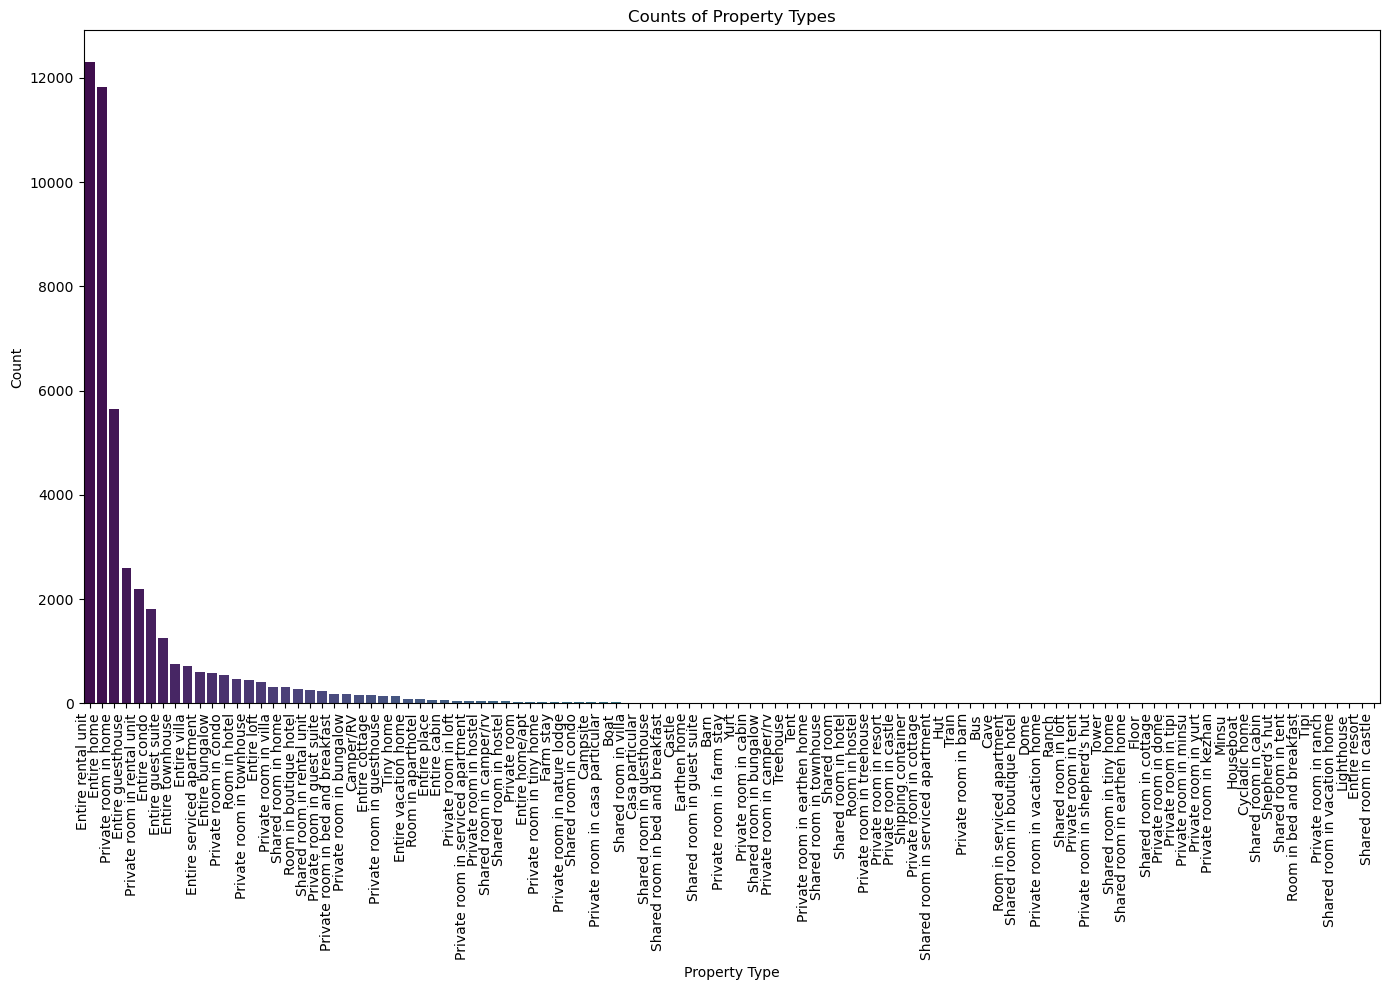

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt


property_counts = listing['property_type'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(14, 10))
sns.barplot(x=property_counts.index, y=property_counts.values, palette='viridis')
plt.title('Counts of Property Types')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


### Observation
The most common and preferred property type in our dataset is 'Entire rental unit', which holds the highest frequency among all property types. Following closely behind are 'Entire home' and 'Private room in home', indicating a preference for entire accommodations or private spaces within homes.

Conversely, among the less frequently occurring property types, 'Shared room in castle' stands out as a rare find. Its infrequent appearance suggests that accommodations of this type are less common in our dataset, possibly catering to niche preferences or unique experiences.






### Average price of the each property

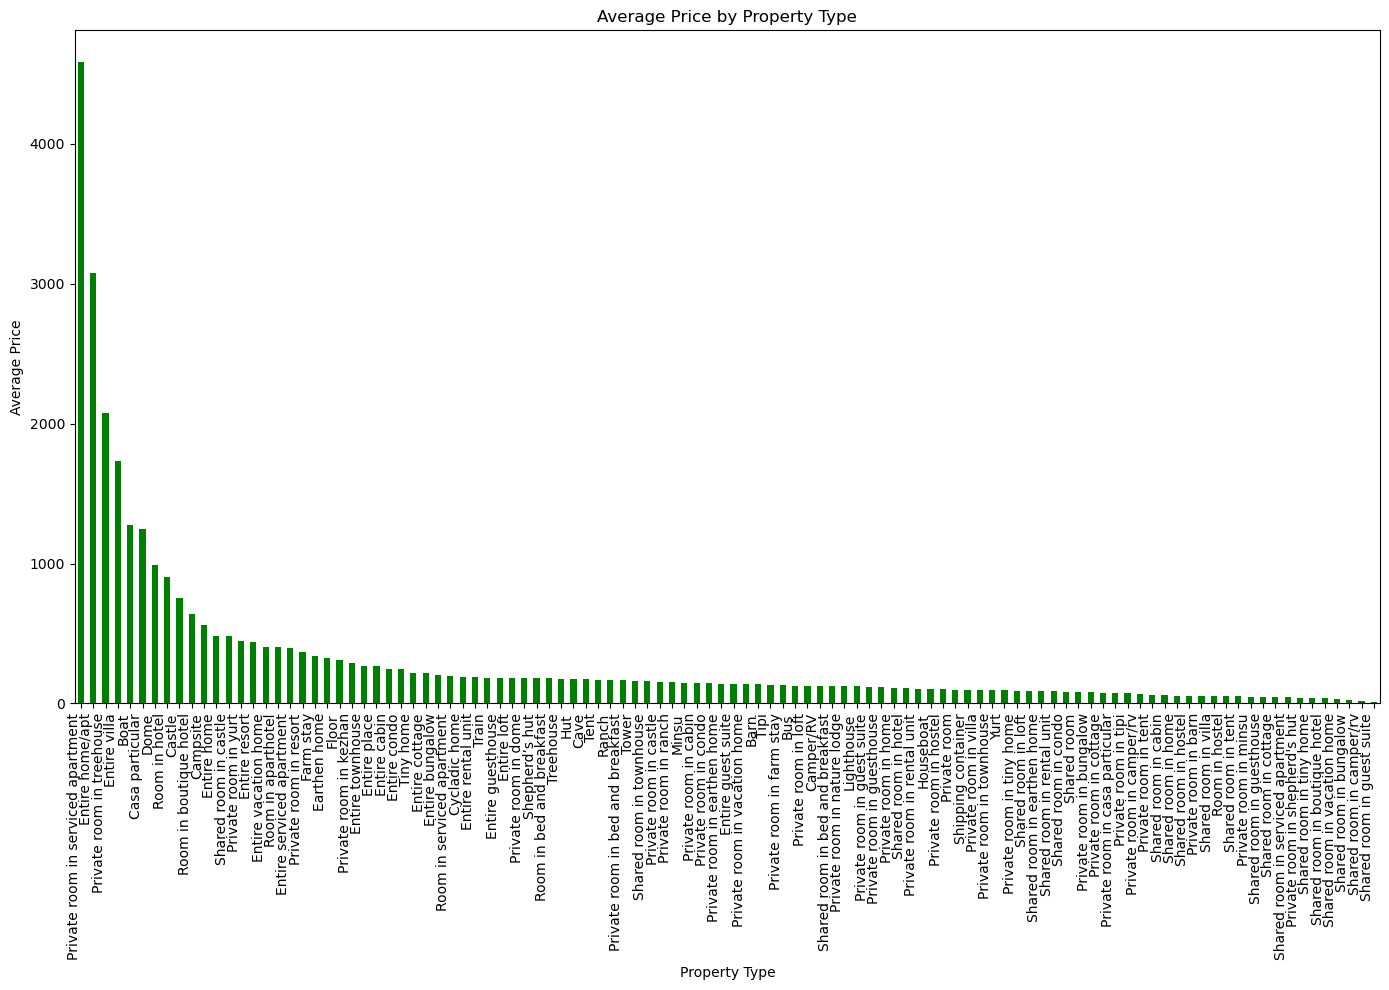

In [93]:
import matplotlib.pyplot as plt

# Calculate the average price for each property type
average_price_by_property_type = listing.groupby('property_type')['price'].mean()

# Sort the property types by average price
sorted_property_types = average_price_by_property_type.sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(14, 10))
sorted_property_types.plot(kind='bar', color='green')
plt.title('Average Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


### Observation
The analysis reveals that "Private room in service apartment" emerges as the most expensive property type, boasting the highest average value among all categories. Following closely behind is "Entire home/apartment," indicating a premium pricing trend for standalone accommodations.

Conversely, the examination highlights "Shared room in guest suite" as the least expensive property type, characterized by its notably lower average price. This distinction underscores its position as a more budget-friendly option within the range of available accommodations.

These insights equip stakeholders in the Airbnb ecosystem with valuable information for discerning the relative affordability and luxury associated with different property types, facilitating more informed decision-making processes.

## Room Type

Here also we are trying to find which is the most common and preferable room type

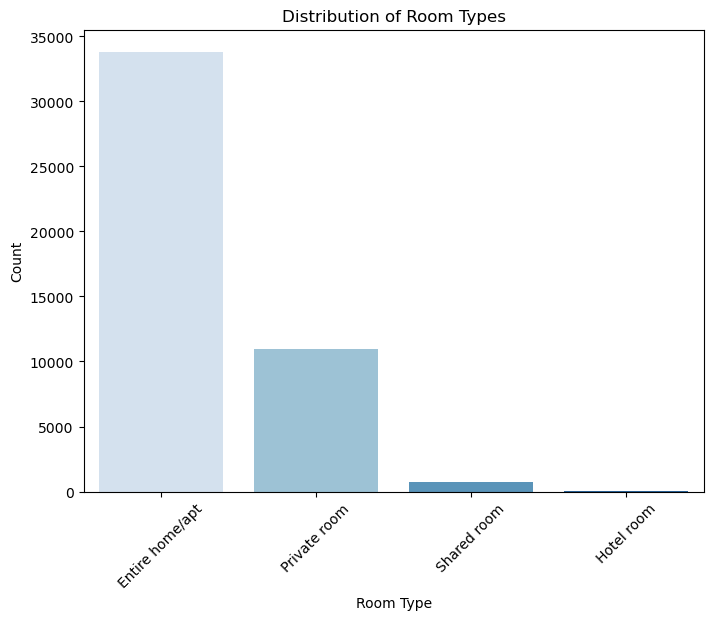

In [94]:
room_type_counts = listing['room_type'].value_counts()

# Step 2: Plot Data
plt.figure(figsize=(8, 6))
sns.barplot(x=room_type_counts.index, y=room_type_counts.values, palette='Blues')
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Observation
The analysis of room types reveals that 'Entire home/apartment' stands out as the most prevalent category.

# host_is_superhost

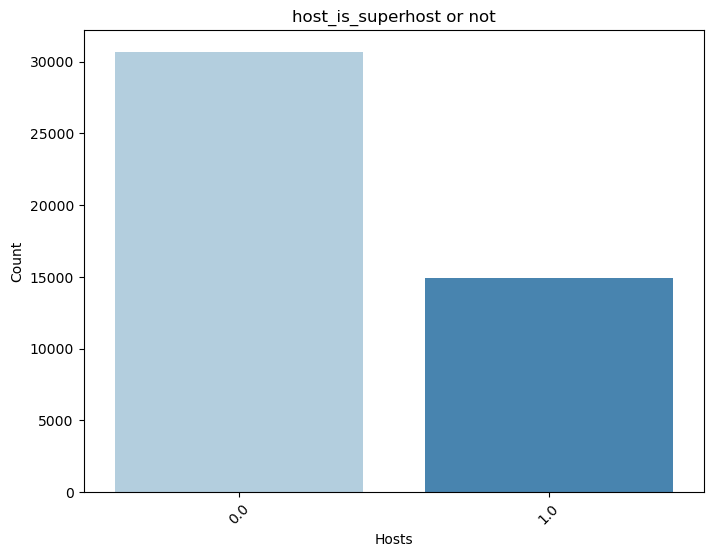

In [95]:

room_type_counts = listing['host_is_superhost'].value_counts()

# Step 2: Plot Data
plt.figure(figsize=(8, 6))
sns.barplot(x=room_type_counts.index, y=room_type_counts.values, palette='Blues')
plt.title('host_is_superhost or not')
plt.xlabel('Hosts')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Observation
The data illustrates that the majority of hosts hold standard status, while less than half of them have achieved the esteemed status of Superhost.






## Question: Does it matter if you're a superhost on Airbnb?
Being a superhost means you've done a great job as a host. To be one, you need to have really high ratings, respond quickly to messages, and accept most booking requests.

Comparing Superhosts with Regular Hosts
In this study, we're looking at whether there's a difference between superhosts and regular hosts. We're only looking at hosts with more than 4 reviews to make sure our results are fair and not based on just a few ratings.

## Lets check the rating camparison between host and superhost

In [96]:
# Step 1: Identify Superhosts
superhosts = listing[listing['host_is_superhost'] == 1]
regular_hosts = listing[listing['host_is_superhost'] == 0]

# Step 2: Calculate Metrics
superhost_avg_rating = superhosts['review_scores_rating'].mean()
regular_host_avg_rating = regular_hosts['review_scores_rating'].mean()

# Step 3: Compare Metrics
print("Average Rating for Superhosts:", superhost_avg_rating)
print("Average Rating for Regular Hosts:", regular_host_avg_rating)

# Step 4: Analyze Differences
if superhost_avg_rating > regular_host_avg_rating:
    print("Superhosts have higher average ratings.")
else:
    print("Regular hosts have higher average ratings.")


Average Rating for Superhosts: 4.9691225720026795
Average Rating for Regular Hosts: 4.821923616320407
Superhosts have higher average ratings.


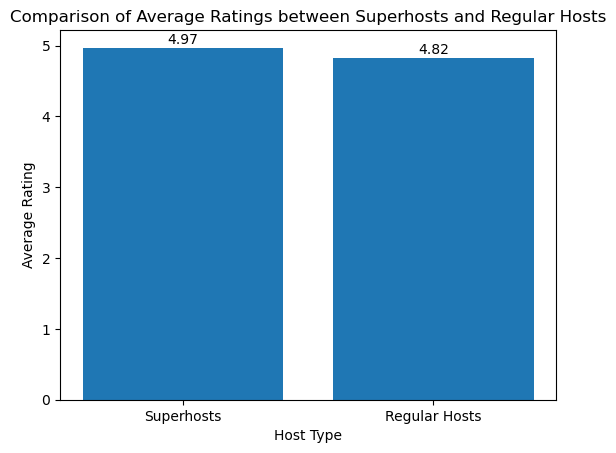

In [97]:
# Create a bar plot
plt.bar(['Superhosts', 'Regular Hosts'], [superhost_avg_rating, regular_host_avg_rating])

# Add labels to the bars
for i, v in enumerate([superhost_avg_rating, regular_host_avg_rating]):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.xlabel('Host Type')
plt.ylabel('Average Rating')
plt.title('Comparison of Average Ratings between Superhosts and Regular Hosts')
plt.show()

### Observation
When discussing ratings, it's worth noting that there is only a slight variance between the ratings of hosts and superhosts. Superhosts typically achieve an impressive average rating of 4.97, while regular hosts receive an average rating of 4.82. This minor difference underscores the overall high quality and satisfaction provided by both types of hosts within the community.

### Checking which top 10 amenities are provided by only superhost

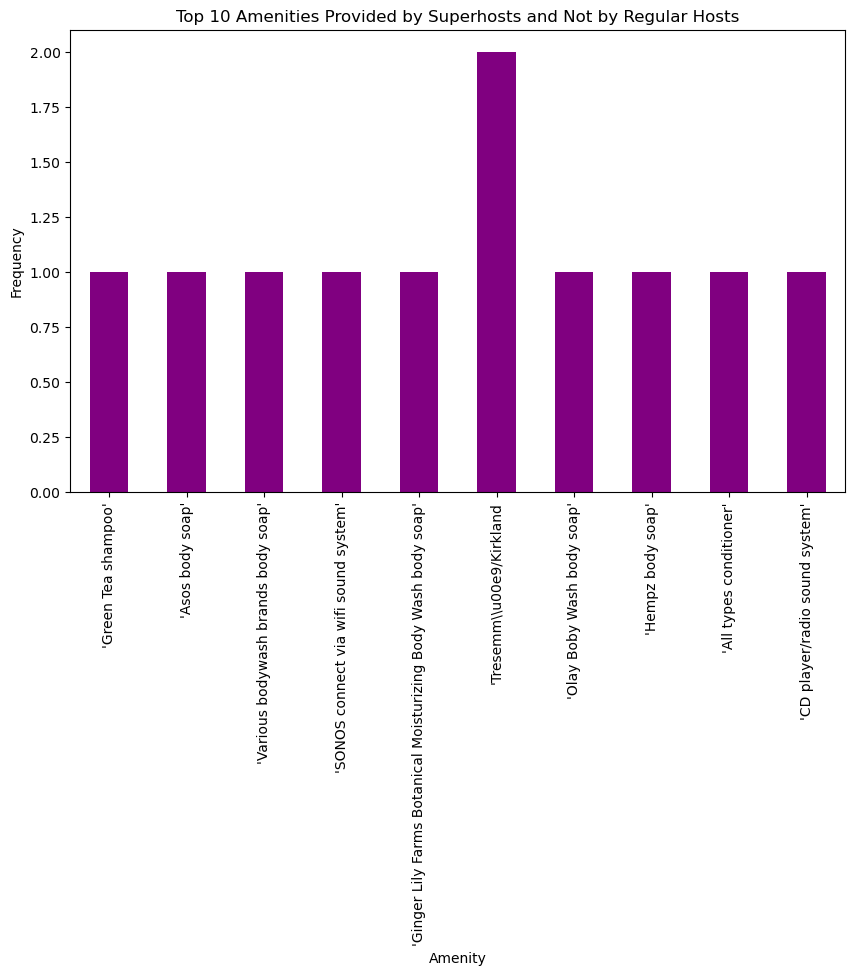

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter rows where host_is_superhost is True (superhosts)
superhost_df = listing[listing['host_is_superhost'] == 1]

# Extract amenities provided by superhosts
superhost_amenities = superhost_df['amenities'].apply(lambda x: str(x).split(','))
superhost_amenities_flat = [amenity.strip() for amenities in superhost_amenities for amenity in amenities]

# Count the occurrences of each amenity for superhosts
superhost_amenities_counts = pd.Series(superhost_amenities_flat).value_counts()

# Filter rows where host_is_superhost is False (regular hosts)
regular_host_df = listing[listing['host_is_superhost'] == 0]

# Extract amenities provided by regular hosts
regular_host_amenities = regular_host_df['amenities'].apply(lambda x: str(x).split(','))
regular_host_amenities_flat = [amenity.strip() for amenities in regular_host_amenities for amenity in amenities]

# Count the occurrences of each amenity for regular hosts
regular_host_amenities_counts = pd.Series(regular_host_amenities_flat).value_counts()

# Find the difference between the sets of amenities provided by superhosts and regular hosts
difference_amenities = set(superhost_amenities_counts.index) - set(regular_host_amenities_counts.index)

# Plot the top 10 difference amenities
top_10_difference_amenities = superhost_amenities_counts[list(difference_amenities)].head(10)
plt.figure(figsize=(10, 6))
top_10_difference_amenities.plot(kind='bar', color='purple')
plt.title('Top 10 Amenities Provided by Superhosts and Not by Regular Hosts')
plt.xlabel('Amenity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()



### Observation
These top 10 amenities, meticulously provided by superhosts, serve as exemplars of their distinguished status. They underscore why superhosts are held in such high regard within the hospitality community.

### Comparison between host response rate

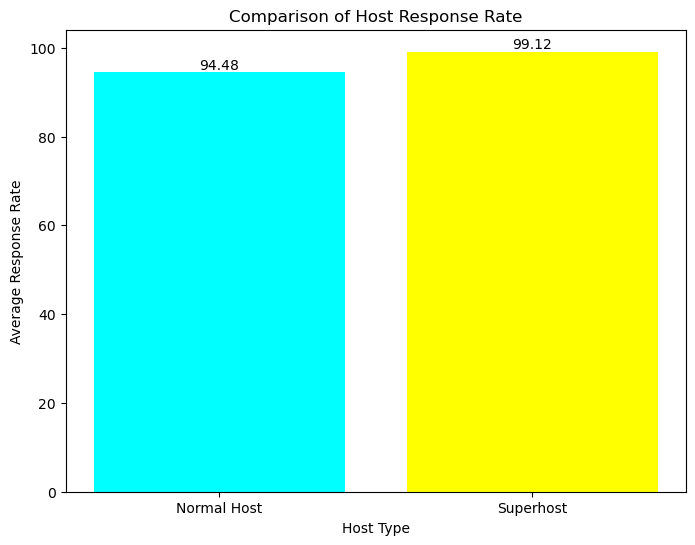

In [99]:
import matplotlib.pyplot as plt

# Group the data by host type and calculate the average response rate for each group
response_comparison = listing.groupby('host_is_superhost')['host_response_rate'].mean().reset_index()

# Plot the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(response_comparison['host_is_superhost'], response_comparison['host_response_rate'], color=['cyan', 'yellow'])
plt.title('Comparison of Host Response Rate')
plt.xlabel('Host Type')
plt.ylabel('Average Response Rate')
plt.xticks(ticks=[0, 1], labels=['Normal Host', 'Superhost'])

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


### Observavtion and suggetion
Encourage hosts to prioritize prompt responses to inquiries and clear communication to improve guest satisfaction and increase the likelihood of becoming a superhost. Emphasize the importance of maintaining high ratings through unique amenities, professional booking handling, and seeking guest feedback. Additionally, joining host communities can provide valuable insights and opportunities for continuous improvement in hosting skills.

### Comparison between average price of host and super host

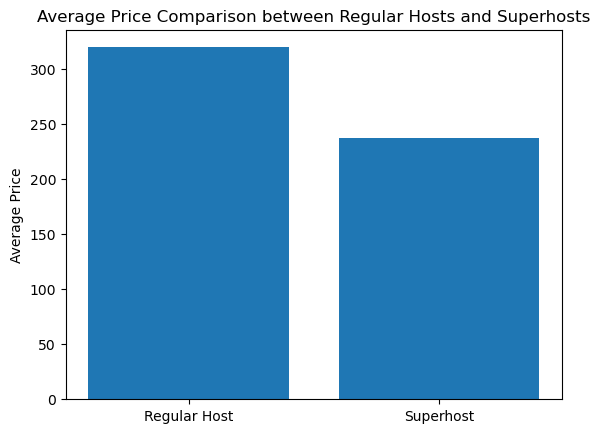

In [100]:
# Calculate average prices for regular hosts and superhosts
avg_regular_host_price = listing.loc[listing['host_is_superhost'] == 0, 'price'].mean()
avg_superhost_price = listing.loc[listing['host_is_superhost'] == 1, 'price'].mean()

# Plotting
plt.bar(['Regular Host', 'Superhost'], [avg_regular_host_price, avg_superhost_price])
plt.ylabel('Average Price')
plt.title('Average Price Comparison between Regular Hosts and Superhosts')
plt.show()


### Observation
Upon analysis, it appears that the average price for regular hosts is higher compared to superhosts. This suggests that potential guests might be inclined towards booking properties hosted by superhosts. Therefore, hosts should consider adjusting their pricing strategy by potentially reducing prices to attract more bookings.

### Advantages of Being a Superhost:
Superhosts enjoy increased visibility, higher ratings, improved bookings, and increased income due to their track record of excellent service.

### Steps for Regular Hosts to Become Superhosts:
Regular hosts should focus on maintaining high ratings, responding promptly to inquiries, meeting superhost criteria, continuously improving their listing and hosting practices, and engaging with the host community to increase their chances of achieving superhost status.

In summary, becoming a superhost on Airbnb offers numerous benefits, and regular hosts can achieve this status by providing exceptional guest experiences and meeting the criteria set by Airbnb.

# Sentiment Analysis

 lets do a sentiment analysis to see positive, negative and neutral reviews

In [101]:
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0         109    449036  2011-08-15       927861         Edwin   
1         109  74506539  2016-05-15     22509885          Jenn   
2        2708  13994902  2014-06-09     10905424       Kuberan   
3        2708  14606598  2014-06-23      2247288       Camilla   
4        2708  39597339  2015-07-25     27974696        Fallon   

                                            comments  
0  The host canceled my reservation the day befor...  
1  Me and two friends stayed for four and a half ...  
2  i had a wonderful stay. Everything from start ...  
3  Charles is just amazing and he made my stay sp...  
4  Staying with Chas was an absolute pleasure. He...

In [102]:
reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      2
comments         352
dtype: int64

In [103]:

# Assuming 'comments' is the column containing comments in your reviews
# Convert any float values or NaN values to empty strings

reviews['comments'] = reviews['comments'].apply(lambda x: '' if pd.isna(x) or isinstance(x, float) else x)



In [104]:
from textblob import TextBlob

In [105]:
#def analyze_sentiment(text):
#    analysis=TextBlob(text)
#    if analysis.sentiment.polarity>0:
#        return 'Positive'
#    elif analysis.sentiment.polarity==0:
#        return 'Neutral'
#    else:
#        return 'Negative'

textblob: TextBlob is a Python library used for processing textual data. It provides a simple API for common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis and more.

One of the key features of TextBlob is its sentiment analysis capability, which allows users to determine the sentiment (positive, negative, or neutral) of a piece of text. This is achieved by analyzing the polarity (positivity or negativity) of the text.

Polarity: Polarity, in the context of sentiment analysis, refers to the measure of the positivity or negativity expressed in a piece of text. It quantifies the emotional tone of the text, indicating whether the sentiment conveyed is positive, negative, or neutral.

In TextBlob, polarity is computed using a lexicon-based approach, where each word in the text is assigned a polarity score, and the overall polarity of the text is calculated based on the average polarity of its constituent words.






In [106]:
#reviews['sentiments']=[str(analyze_sentiment(x)) for x in reviews.comments]

In [107]:
#import pickle

#with open('sentiment_analysis', 'wb') as f:
#    pickle.dump(reviews, f)


In [108]:
with open('sentiment_analysis', 'rb') as f:
    reviews = pickle.load(f)


In [109]:
reviews.sample(4)

listing_id                   id        date  reviewer_id  \
1143020    46360558   648581110929192064  2022-06-13    454420406   
1109914    44496016            747160135  2021-04-09    150998066   
152752      3544380   476897055608971346  2021-10-19    353615094   
27023        381068  1006688010392701606  2023-10-20     67585317   

         reviewer_name                                           comments  \
1143020         Jasper  Clean and quiet, great place. Far away from al...   
1109914          Laura  Appreciate the last minute booking acceptance ...   
152752           Angel  Great place to stay everything you can think o...   
27023    Jill And John   Wonderful surroundings.  Beautiful place.  Bravo   

        sentiments  
1143020   Positive  
1109914   Positive  
152752    Positive  
27023     Positive

# Bag Of Words

 We are focusing on those words who are common in positive review

In [110]:
reviews_positive = reviews[reviews['sentiments']== 'Positive']
reviews_negative = reviews[reviews['sentiments']== 'Negative']

In [111]:
# positive comments
positive_comments = reviews_positive.comments.tolist()


In [112]:
# negative comments
negative_comments = reviews_negative.comments.tolist()

In [113]:
positive_comments[1:3]

['i had a wonderful stay. Everything from start to the end was perfect.<br/>Will come back again.',
 'Charles is just amazing and he made my stay special. He is so nice, helpful and absolutely polite. Charles is always there when you need some advice or help and totally respects your privacy too. I could concentrate on my work while Charles was doing his work - also absolutely quiet. The apartment is perfectly tidy, very clean, with tasty furniture and beautiful details. My bedroom even had a desk in it. Also, the apartment is located in a perfect area, most sightseeing spots are in walking distance and there are some very nice restaurants around as well. I highly recommend this place! ']

In [114]:
negative_comments[1:3]

['Really nice location in Venice.  Unfortunately, there were a few fleas in the bed (from the cat, I think), and I got a half dozen bites or so each night :(',
 'Unfortunately, I was really disappointed with this spot, and I wouldn\'t recommend it for the price-point that it\'s at. Upon arrival, I realized that it was a situation that I would just have to deal with, or not, since there was nothing that could be done. I inevitably left 2 days prior to the end of my booking because it was too uncomfortable. <br/>- The room is not pictured in the post, and I found out that this was by design. It ended up being in an office, that was full of things wall-to-wall with no space to put your things except for the floor. There was also no bed; it was a chair-futon that had sheets on it. The futon was quite small - I\'m 5\'7" and my feet hung over the edge - and it was a bit broken, so it slouched significantly down on one side. Needless to say, it was a struggle to get rested with futon bars on 

 this function prepares the text data by removing noise, standardizing the format, and reducing redundancy, making it suitable for NLP tasks such as text classification, sentiment analysis, and topic modeling.v

In [115]:
# Creating a function that will preprocess and standardize the text for NLP 
def preprocess(text):
    ''' This function takes text to preprocess and standardize it for the purpose of NLP '''
 
    # Lowercase the text 
    text = text.str.lower()
    text= text.apply(lambda x: x.replace('</b>', ''))
    text= text.apply(lambda x: x.replace('<b>', ''))
    text= text.apply(lambda x: x.replace('<br />', ''))
    text= text.apply(lambda x: x.replace('<br/>', ''))
    text= text.apply(lambda x: x.replace('br', ''))
    
    # Remove punctuations using string module with regular expression
    text = text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # Split string by whitespace and remove extra whitespaces 
    text = text.apply(lambda x: x.split())

    # Remove stopwords of both english, german and french as these are the languages in the dataset
    stopwords = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('french') + nltk.corpus.stopwords.words('german')
    text = text.apply(lambda x: [word for word in x if word not in stopwords])

    # Lemmatize text to group together words with the same root or lemma
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    text = text.apply(lambda x: ' '.join(x))

    return text

### Positive

In [116]:
# preprocessing the positive comments- this code takes long to run
#processed_positive = preprocess(reviews_positive['comments'])


In [117]:
#processed_positive.head(2)

In [118]:
#with open('processed_positive.pickle', 'wb') as f:
#    pickle.dump(processed_positive, f)


In [119]:
with open('processed_positive.pickle', 'rb') as f:
    processed_positive = pickle.load(f)


In [120]:
processed_positive.head()

1    two friend stayed four half month great place ...
2    wonderful stay everything start end perfect co...
3    charles amazing made stay special nice helpful...
4    staying chas absolute pleasure accommodating r...
5    charles wonderful host enjoyed stay bed comfor...
Name: comments, dtype: object

### Negative 

In [121]:
# preprocessing the positive comments- this code takes long to run
# processed_negative = preprocess(reviews_negative['comments'])


In [122]:
#with open('processed_negative.pickle', 'wb') as f:
#    pickle.dump(processed_negative, f)


In [123]:
with open('processed_negative.pickle', 'rb') as f:
    processed_negative = pickle.load(f)


In [124]:
processed_negative.head()

248    let first say michaela good host friendly made...
254    really nice location venice unfortunately flea...
283    unfortunately really disappointed spot recomme...
734    lage tiny house super kommt schnell strand umg...
756    confused positive comment place picture make c...
Name: comments, dtype: object

##### Unigram count vectorizer for positive words

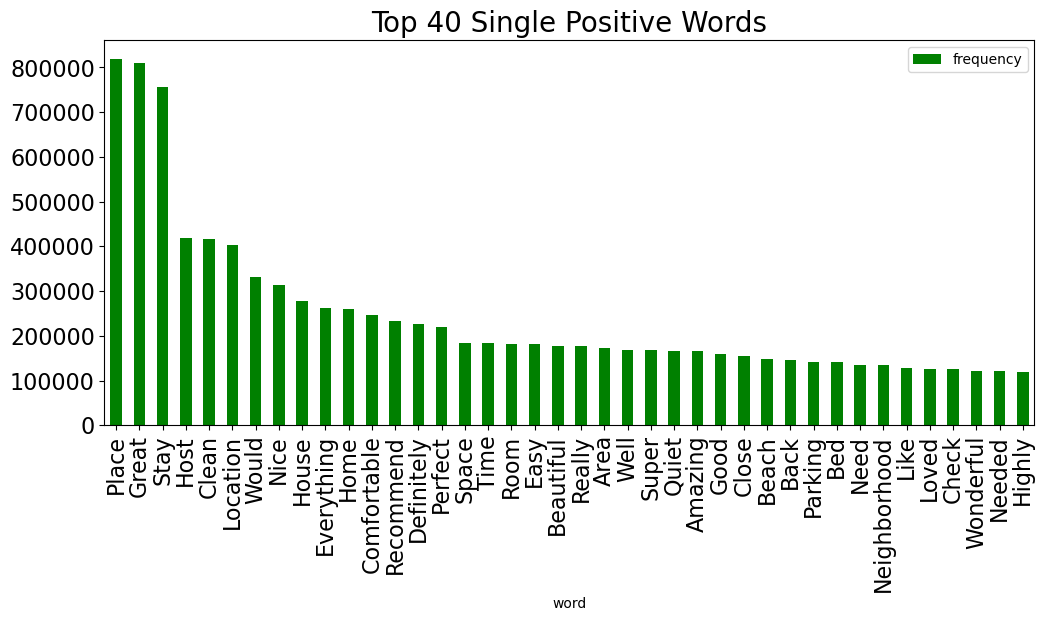

In [125]:
# instantiating count vectorizer for unigrams 
cv_pos_unigram = CountVectorizer()
cv_pos_matrix = cv_pos_unigram.fit_transform(processed_positive)
cv_pos_total = cv_pos_matrix.sum(axis=0)

cv_pos_freq = [(word.title(), cv_pos_total[0, i]) for word, i in cv_pos_unigram.vocabulary_.items()]
cv_pos_freq = sorted(cv_pos_freq, key = lambda x: x[1], reverse = True)
cv_pos_frequency = pd.DataFrame(cv_pos_freq, columns=['word', 'frequency'])

# Plotting Top 40 Most Frequent unigrams in positive comments with CV 
cv_pos_frequency.head(40).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'green')
plt.title('Top 40 Single Positive Words', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

#### Unigram count vectorizer for negative words

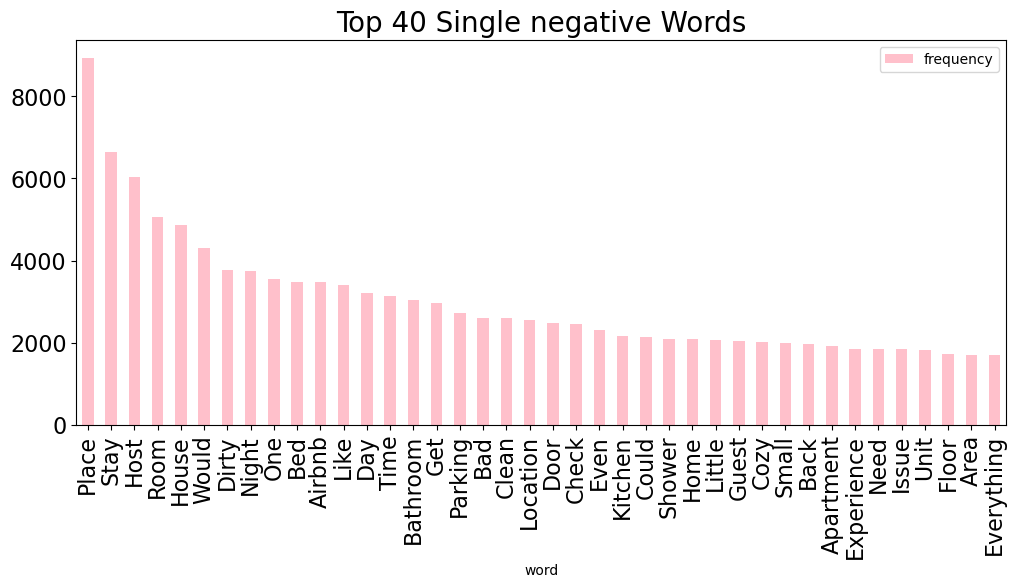

In [126]:
# instantiating count vectorizer for unigrams 
cv_pos_unigram = CountVectorizer()
cv_pos_matrix = cv_pos_unigram.fit_transform(processed_negative)
cv_pos_total = cv_pos_matrix.sum(axis=0)

cv_pos_freq = [(word.title(), cv_pos_total[0, i]) for word, i in cv_pos_unigram.vocabulary_.items()]
cv_pos_freq = sorted(cv_pos_freq, key = lambda x: x[1], reverse = True)
cv_pos_frequency = pd.DataFrame(cv_pos_freq, columns=['word', 'frequency'])

# Plotting Top 40 Most Frequent unigrams in negative comments with CV 
cv_pos_frequency.head(40).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'pink')
plt.title('Top 40 Single negative Words', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

#### Bigram count vectorizer for positive words

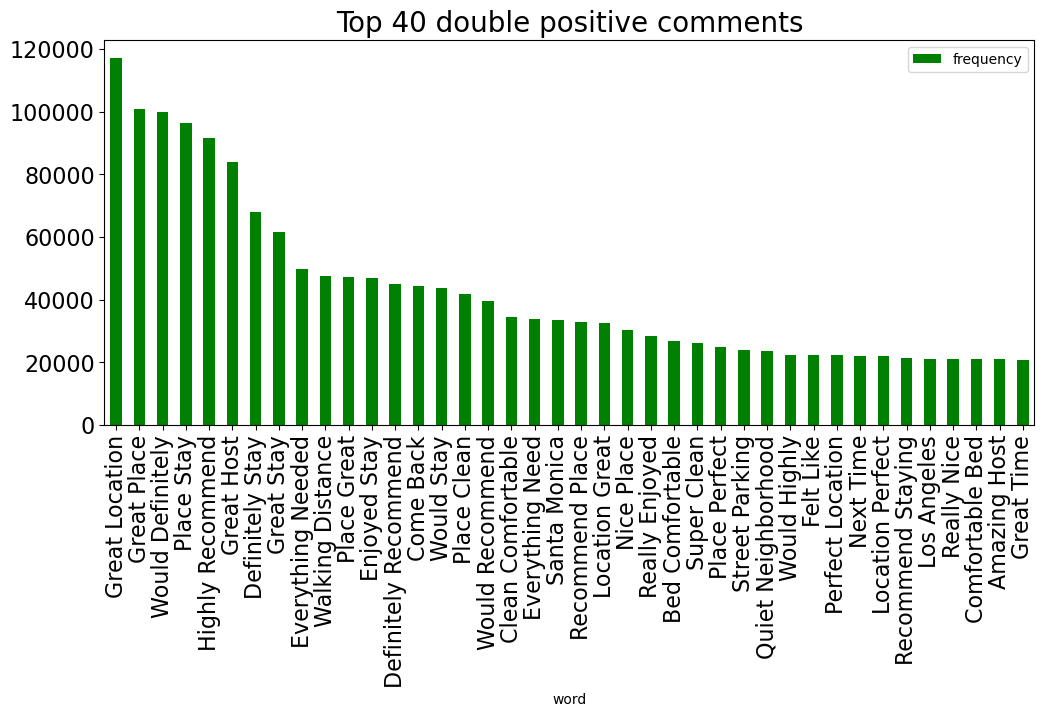

In [127]:
# instantiating count vectorizer for bigrams 
cv1_pos_bigram = CountVectorizer(ngram_range=(2,2))
# fitting to positive comments
cv1_pos_matrix = cv1_pos_bigram.fit_transform(processed_positive)
# getting the sum
cv1_pos_total = cv1_pos_matrix.sum(axis=0)
# creating a tuple of word vs freq
cv1_pos_freq = [(word.title(), cv1_pos_total[0, i]) for word, i in cv1_pos_bigram.vocabulary_.items()]
cv1_pos_freq = sorted(cv1_pos_freq, key = lambda x: x[1], reverse = True) # sorting
# pandas dataframe of the list of tuples
cv1_pos_frequency = pd.DataFrame(cv1_pos_freq, columns=['word', 'frequency'])

# Plotting Top 40 Most Frequent bigrams in positive comments with CV 
cv1_pos_frequency.head(40).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'green')
plt.title('Top 40 double positive comments', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

#### Bigram count vectorizer for negative words

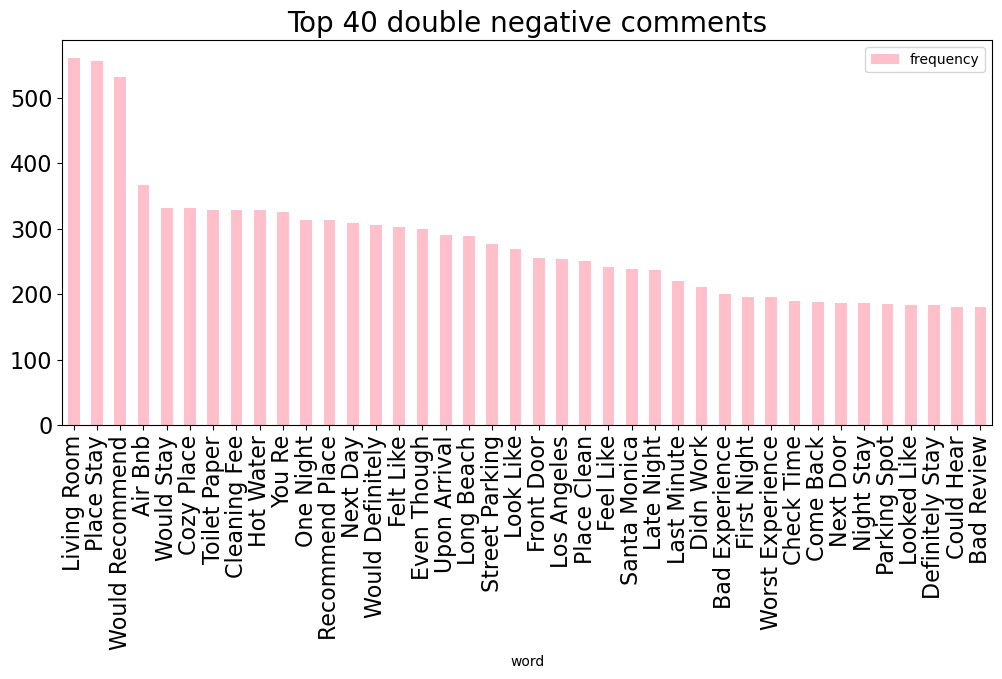

In [128]:
# instantiating count vectorizer for bigrams 
cv1_pos_bigram = CountVectorizer(ngram_range=(2,2))
# fitting to negative comments
cv1_pos_matrix = cv1_pos_bigram.fit_transform(processed_negative)
# getting the sum
cv1_pos_total = cv1_pos_matrix.sum(axis=0)
# creating a tuple of word vs freq
cv1_pos_freq = [(word.title(), cv1_pos_total[0, i]) for word, i in cv1_pos_bigram.vocabulary_.items()]
cv1_pos_freq = sorted(cv1_pos_freq, key = lambda x: x[1], reverse = True) # sorting
# pandas dataframe of the list of tuples
cv1_pos_frequency = pd.DataFrame(cv1_pos_freq, columns=['word', 'frequency'])

# Plotting Top 40 Most Frequent bigrams in negative comments with CV 
cv1_pos_frequency.head(40).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'pink')
plt.title('Top 40 double negative comments', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

### Observation
From both the unigram and bigram analysis, it's evident that individuals highly value certain aspects when choosing accommodations. They prioritize great locations, good stay, friendly hosts, well-equipped amenities, breathtaking views, safety, beauty, and cleanliness. Moreover, the likelihood of revisiting a listing increases significantly if these criteria are met, indicating the strong influence of these factors on overall satisfaction and loyalty.

 From both the unigram and bigram analysis, we've identified some negative feedback. These comments often critique aspects such as locations, living room conditions, the overall stay experience, insufficient or poor-quality amenities, issues with toilet paper availability, extended distances to the beach, concerns regarding safety, subpar cleanliness and aesthetics, and disappointing parking arrangements. These are areas where hosts should direct their attention and aim to improve to enhance guest satisfaction.

# Feature Engineering

In [129]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              45591 non-null  int64   
 1   listing_url                     45591 non-null  object  
 2   host_url                        45591 non-null  object  
 3   name                            45591 non-null  object  
 4   neighborhood_overview           45591 non-null  object  
 5   neighbourhood_cleansed          45591 non-null  object  
 6   host_response_time              45591 non-null  object  
 7   host_response_rate              45591 non-null  float64 
 8   host_acceptance_rate            45591 non-null  float64 
 9   host_is_superhost               45591 non-null  float64 
 10  latitude                        45591 non-null  float64 
 11  longitude                       45591 non-null  float64 
 12  property_type     

The aim is to create a recommendation system similar to a search engine. This system will take into account important characteristics while looking at listings. This is crucial because the model will take in information from users and then find the best listings that match what the user is looking for.

In [130]:
# Create a copy of listing dataframe
copy_listing = listing.copy()

In [131]:
# Lets amenities from list to string type
copy_listing['amenities'] = copy_listing['amenities'].apply(lambda x: ','.join(x))


In [132]:
# changing dataframe view settings
pd.set_option('display.max_columns', None)

In [133]:
# joining the object type features to create a content feature
copy_listing['contents'] = (copy_listing['name'] + ' ' 
                                + copy_listing['neighborhood_overview'] + ' ' 
                                + copy_listing['property_type'] + ' ' 
                                + copy_listing['room_type'] + ' ' 
                                + copy_listing['amenities']) 

In [134]:
# preprocessing contents feature
copy_listing['contents'] = preprocess(copy_listing['contents'])


In [135]:
copy_listing['contents'][6]

'home los angeles · ★4 63 · 1 bedroom · 1 bed · 1 shared bath neighborhood quiet save shopping mall area movie theater grocery store 10 minute walk house go direction many little eatery indulge various cultural food sushi vegan thai food mexican much close everything great biking beach walking distance marina shopping mall 90 fwy provides easy access many place private room home private room high chair shampoo kitchen stove single level home iron essential carbon monoxide alarm coffee maker first aid kit wifi free parking premise heating long term stay allowed lockbox lock bedroom door luggage dropoff allowed shared backyard u2013 fully fenced self check cooking basic hot water bed linen oven fire extinguisher child u2019s book toy hair dryer refrigerator free street parking smoke alarm washer garden view dish silverware hanger'

# Recommendation System

### Count Vectorizer

In [136]:
# Convert the content column to a matrix of word counts
# Most frequent words with Count Vectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_matrix = cv.fit_transform(copy_listing['contents'])
cv_total = cv_matrix.sum(axis=0)

cv_freq = [(word.title(), cv_total[0, i]) for word, i in cv.vocabulary_.items()]
cv_freq = sorted(cv_freq, key = lambda x: x[1], reverse = True)
# word frequency dataframe           
cv_frequency = pd.DataFrame(cv_freq, columns=['word', 'frequency'])    

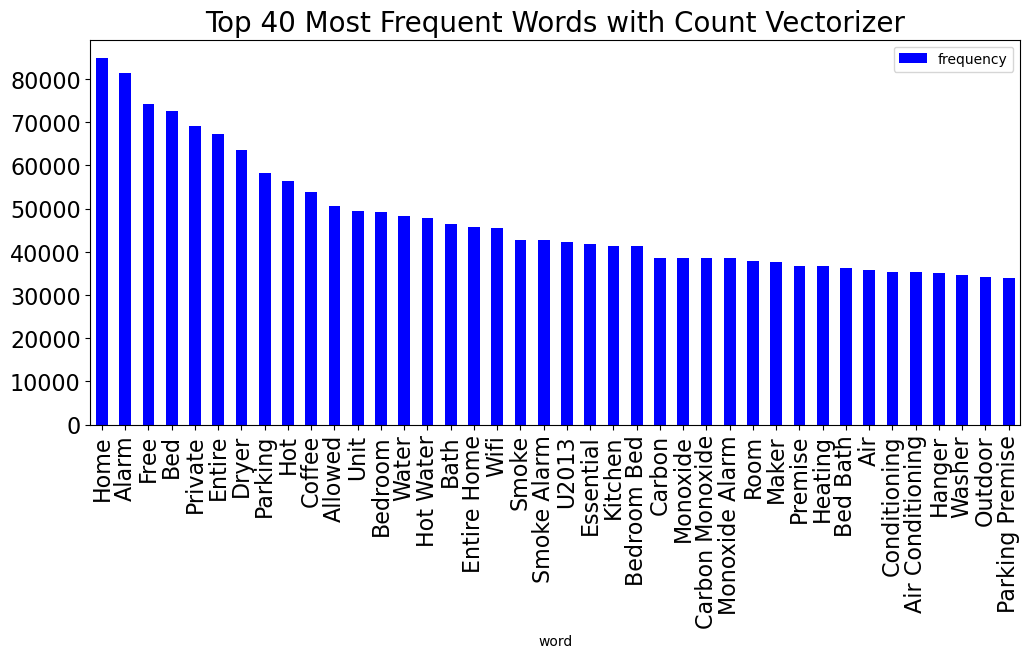

In [137]:
# Plotting Top 40 Most Frequent Words in contents feature with CV 
cv_frequency.head(40).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'blue')
plt.title('Top 40 Most Frequent Words with Count Vectorizer', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

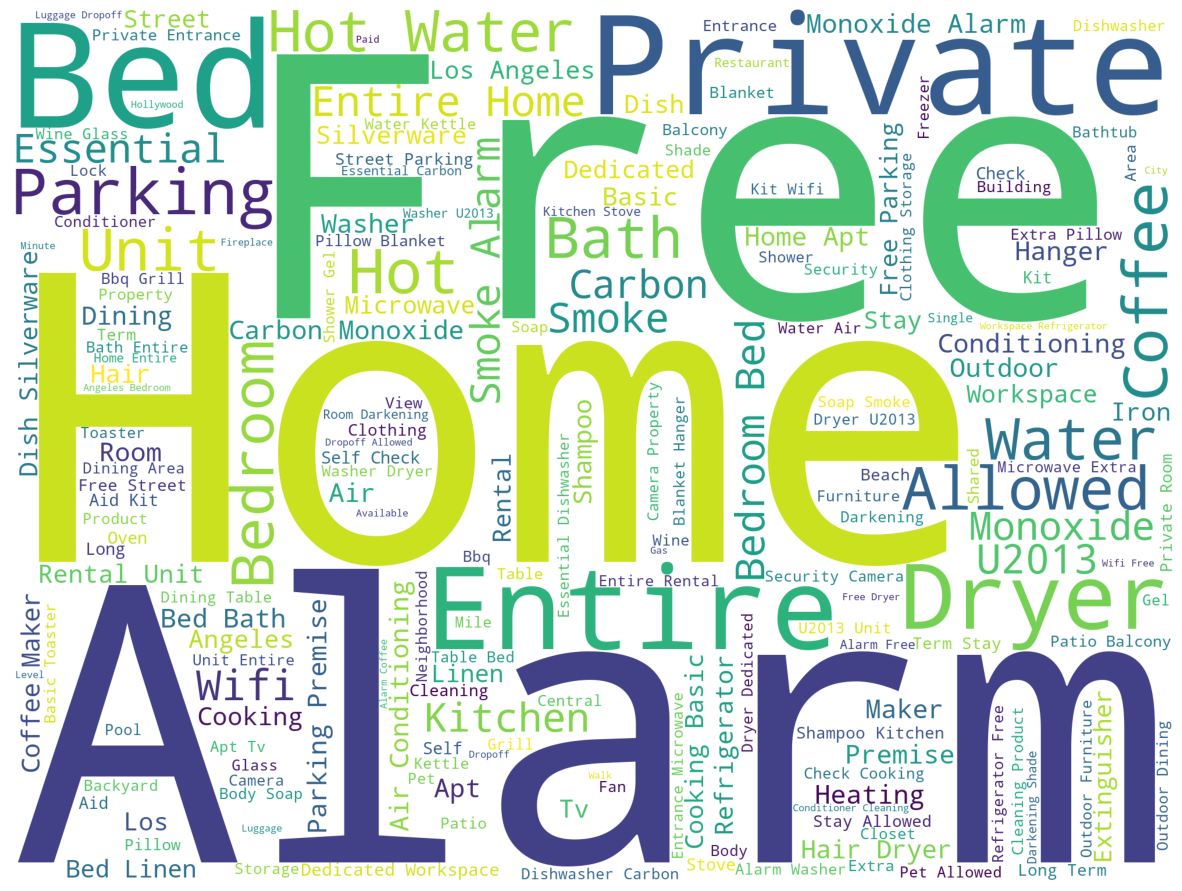

In [138]:
# Wordcloud of the words with Count Vectorizer
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(cv_freq))
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis('off');

In [139]:
# transfoming an example query into a vector
query = cv.transform(['I want an apartment in cape town with free parking'])
# printing the simmilarities of the query to the records in contents
print(cosine_similarity(query, cv_matrix))

[[0.09687505 0.10810247 0.06655583 ... 0.14146066 0.         0.03436041]]


In [140]:
# creating a variable for the simmilarities
similarity = cosine_similarity(query, cv_matrix)
# top 5 similar lisitngs
sorting = np.argsort(similarity[0])

In [141]:
# displaying top 5 scores with count vectorizer
cv_scores = similarity[0]
cv_scores.sort()
cv_scores[-5:]

array([0.23806401, 0.23809524, 0.24196696, 0.2448583 , 0.25031309])

In [142]:
# checking the most similar listing
pd.DataFrame(listing.loc[13030]).T

id                            listing_url  \
13030  35072050  https://www.airbnb.com/rooms/35072050   

                                         host_url  \
13030  https://www.airbnb.com/users/show/29591316   

                                                    name  \
13030  Rental unit in Los Angeles · 2 bedrooms · 2 be...   

      neighborhood_overview neighbourhood_cleansed  host_response_time  \
13030                                Beverly Grove  within a few hours   

      host_response_rate host_acceptance_rate host_is_superhost  latitude  \
13030              100.0                 89.0               1.0  34.07364   

      longitude       property_type        room_type accommodates  \
13030 -118.3807  Entire rental unit  Entire home/apt            5   

      num_of_bathrooms bedrooms beds  \
13030              2.0      5.0  2.0   

                                               amenities  price  \
13030  [Private patio or balcony, Elevator, Shampoo, ...  300.0   

      number_of_reviews review_scores_rating review_scores_accuracy  \
13030                 1                  5.0                    5.0   

      review_scores_cleanliness review_scores_checkin  \
13030                       5.0                   5.0   

      review_scores_communication review_scores_location instant_bookable  \
13030                         5.0                    5.0                0   

      calculated_host_listings_count amenities_count hosting_duration  \
13030                             11              38                8   

      response_rate acceptance_rate accommodate amenities_binned  
13030        90-100           71-89  5-8 people         above 30

In [143]:
# basic recommender using count vectorized words
def recommend_five():
    ''' This function asks the user a question and then takes in the answer to finds the top 5 similar listings '''
    
    question = input('What are some features you are interested in? ')
    lowercased = question.lower()
    # count vectorize the question
    inquiry = cv.transform([question])

    # Calculate cosine similarity of inquiry with the cv_matrix
    similarity = cosine_similarity(inquiry, cv_matrix)
    
    # Obtain the index then sort, picking top 5
    nums = np.argsort(similarity[0])[-5:]

    #return the top 5
    return listing['name'].loc[nums]

In [144]:
# checking whether its working
recommend_five()

What are some features you are interested in? private room


2648    Home in Monrovia · ★4.0 · 1 bedroom · 1 bed · ...
2016          Home in Duarte · 1 bedroom · 1 bed · 1 bath
6442         Home in Arcadia · 1 bedroom · 1 bed · 1 bath
5355      Home in Compton · 1 bedroom · 1 bed · 2.5 baths
5645    Home in Alhambra · 2 bedrooms · 2 beds · 1 pri...
Name: name, dtype: object

# TF-IDF Vectorization
TF-IDF is a technique that assigns a numerical value to words, indicating their importance in a document within a corpus. N-grams refer to continuous sequences of words, symbols, or tokens found in a document.

The text will undergo vectorization using TF-IDF, considering Unigrams, Bigrams, and Trigrams, in order to assess the prevalence of the most common words within each n-gram.

### Unigram

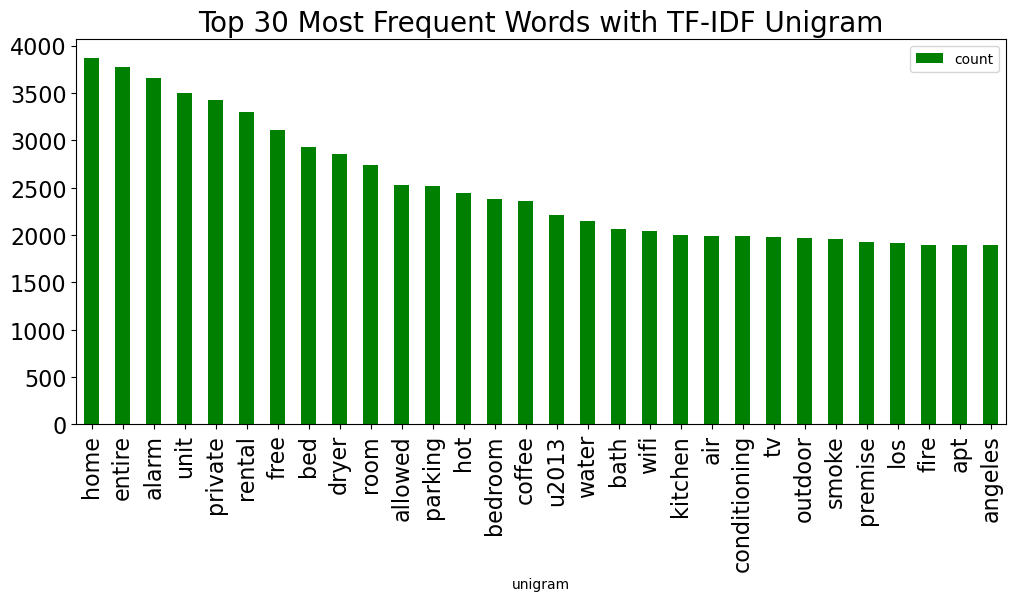

In [145]:
# Converting text descriptions into vectors using TF-IDF using Unigrams
tf = TfidfVectorizer(ngram_range=(1, 1), lowercase = False)
tf_matrix = tf.fit_transform(copy_listing['contents'])
tf_total = tf_matrix.sum(axis=0) 
# Finding the word frequency
tf_freq = [(word, tf_total[0, idx]) for word, idx in tf.vocabulary_.items()]
tf_freq = sorted(tf_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
unigram = pd.DataFrame(tf_freq, columns = ['unigram', 'count'])

# Plotting the bigram distribution of top 30 words 
unigram.head(30).plot(x='unigram', y='count', kind='bar', figsize=(12, 5), color = 'green')
plt.title('Top 30 Most Frequent Words with TF-IDF Unigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

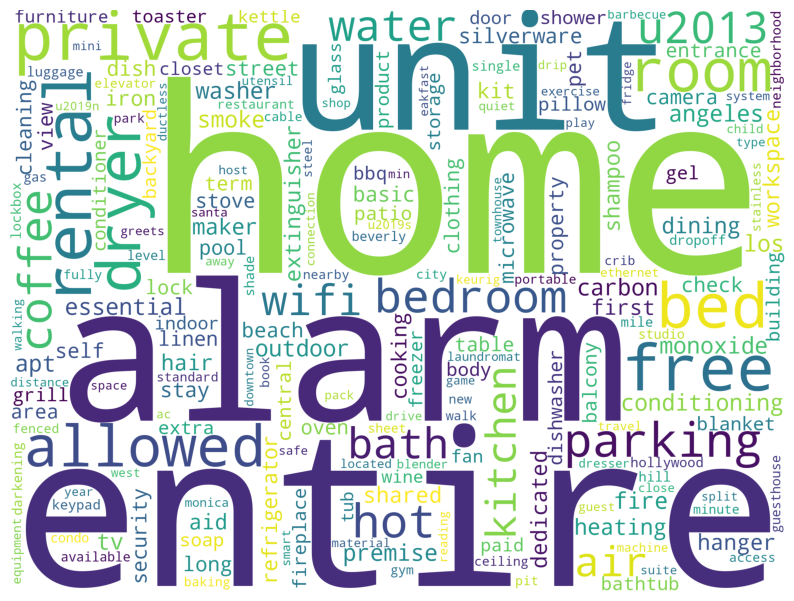

In [146]:
# Wordcloud of the words with TF-IDF Vectorizer with Unigram
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

### Observations:

Listing descriptions predominantly highlight amenities, with notable mentions including:
* Entire rooms
* Private rooms
* Parking facilities
* Access to TV and Wi-Fi
* Emphasis on location or views of the beach, likely influenced by the Western Cape's coastal setting.

### Bigram

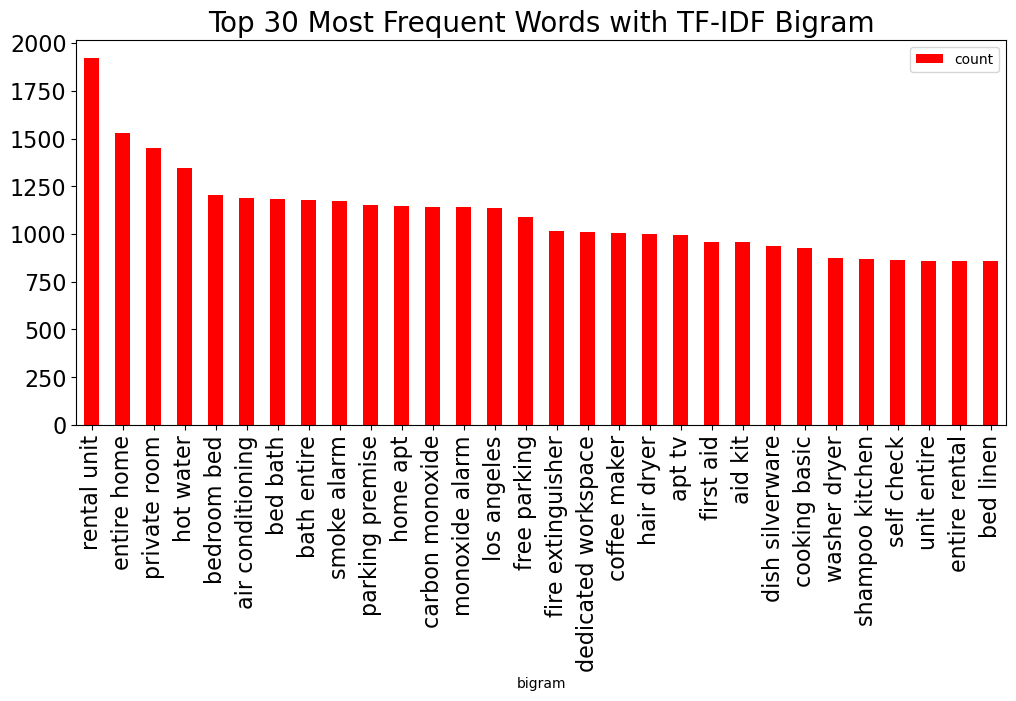

In [147]:
# Converting text descriptions into vectors using TF-IDF using Bigram
tf2 = TfidfVectorizer(ngram_range=(2, 2), lowercase = False)
tf2_matrix = tf2.fit_transform(copy_listing['contents'])
tf2_total = tf2_matrix.sum(axis=0) 
# Finding the word frequency
tf2_freq = [(word, tf2_total[0, idx]) for word, idx in tf2.vocabulary_.items()]
tf2_freq = sorted(tf2_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
bigram = pd.DataFrame(tf2_freq, columns = ['bigram', 'count'])

# Plotting the bigram distribution of top 30 words
bigram.head(30).plot(x='bigram', y='count', kind='bar', figsize=(12, 5), color = 'red')
plt.title('Top 30 Most Frequent Words with TF-IDF Bigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

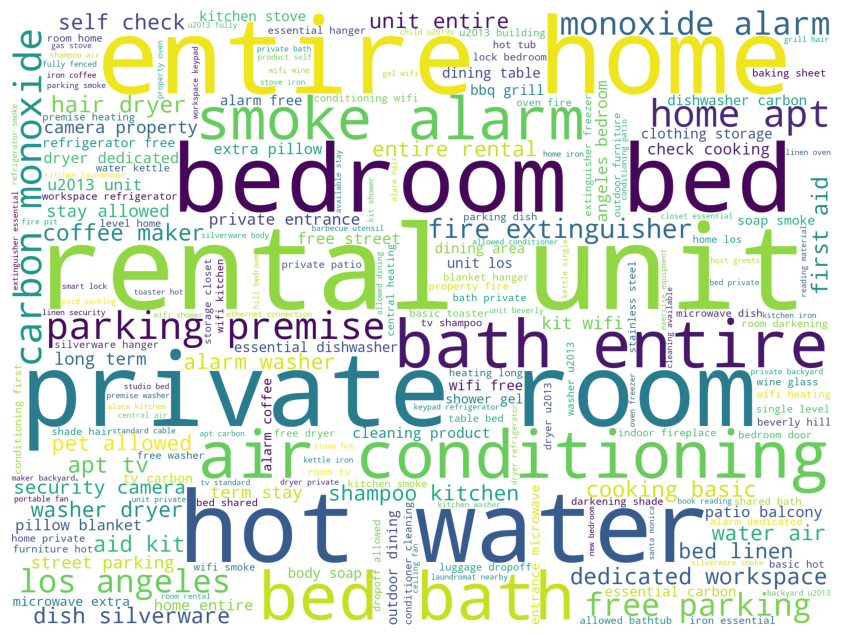

In [148]:
# Wordcloud of the words with TF-IDF Vectorizer with Bigram
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf2_freq))
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud)
plt.axis('off');

### Observations:

Listing descriptions predominantly highlight amenities, with notable mentions including:
* Entire home
* rental unit
* private room
* Access to TV and Wi-Fi
* Emphasis on location or views of the beach, likely influenced by the Western Cape's coastal setting.

### Tigram

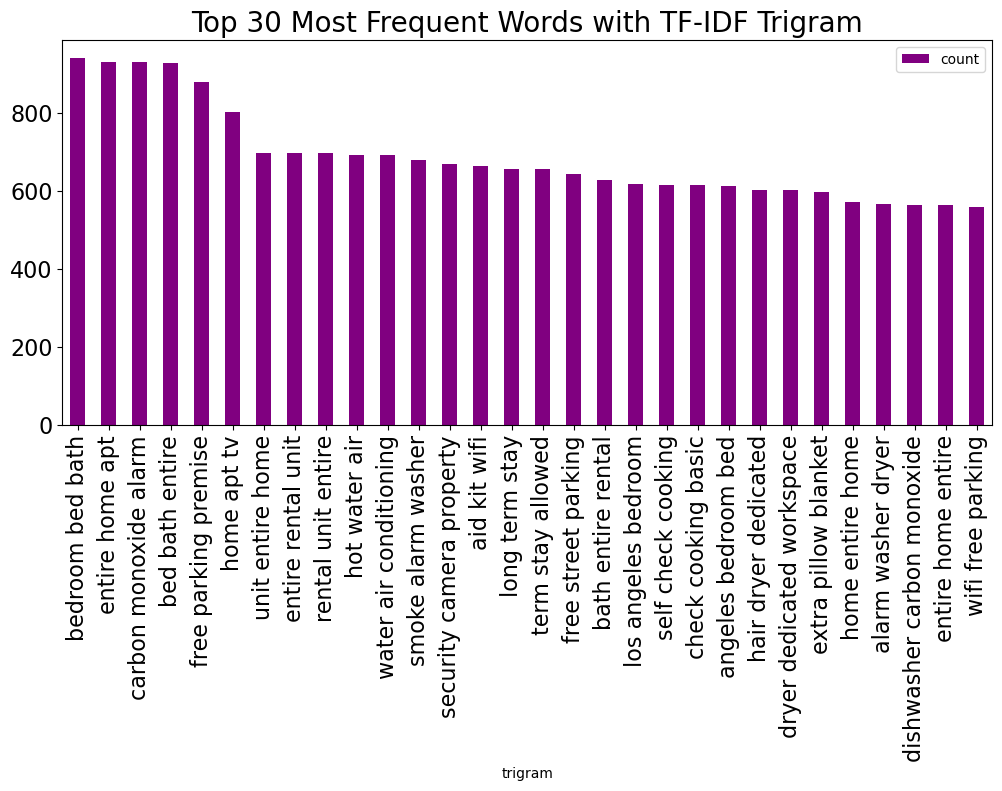

In [149]:
# Converting text descriptions into vectors using TF-IDF using Trigram
tf3 = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tf3_matrix = tf3.fit_transform(copy_listing['contents'])
tf3_total = tf3_matrix.sum(axis=0) 

# Finding the word frequency
tf3_freq = [(word, tf3_total[0, idx]) for word, idx in tf3.vocabulary_.items()]
tf3_freq =sorted(tf3_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
trigram = pd.DataFrame(tf3_freq, columns = ['trigram', 'count'])

# Plotting the trigram distribution of top 30 words 
trigram.head(30).plot(x='trigram', y='count', kind='bar', figsize=(12, 5), color = 'purple')
plt.title('Top 30 Most Frequent Words with TF-IDF Trigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

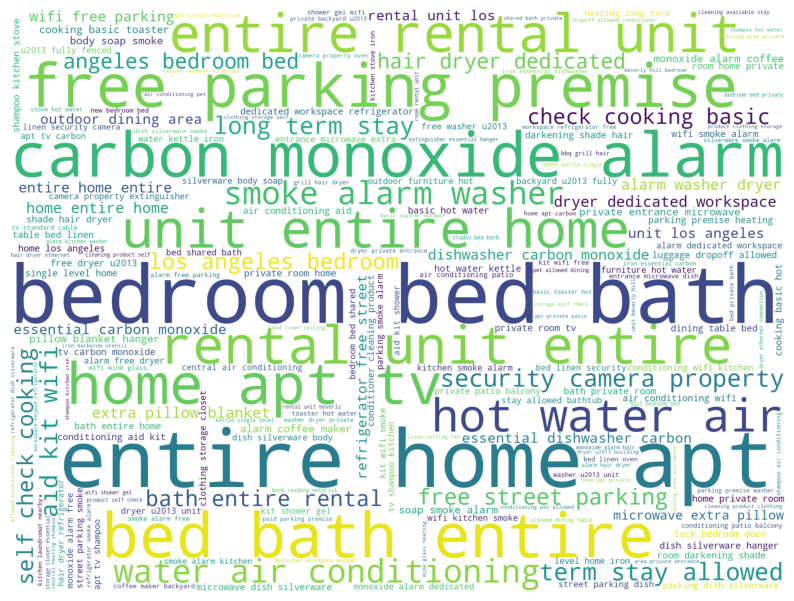

In [150]:
# Wordcloud of the words with TF-IDF Vectorizer with Trigram
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf3_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

# Recommender Using TF-IDF
For our recommender system, we'll leverage cosine similarity, which calculates similarities between listings. We'll employ the Bigram TF-IDF vectorizer as single words might lack contextual meaning. This approach allows us to capture more nuanced relationships between words and enhance the effectiveness of our recommendations.

### with the help of bigram

In [151]:
# recommender using bigrams
def bi_recommender(content):
    lowercased = content.lower()
    inquiry = tf2.transform([lowercased])

    similarity = cosine_similarity(inquiry, tf2_matrix)
    nums = np.argsort(similarity[0])[-5:]

    ls = similarity[0]
    ls.sort()
    print(ls[-5:])
    print(nums)

    return listing[['name', 'listing_url']].loc[nums]

In [152]:
bi_recommender('I want an apartment with swimming pool and parking')

[0.13048173 0.13638157 0.15182327 0.15956245 0.20159658]
[ 2369  1759  6458 20949 11572]


name  \
2369   Condo in Valley Village · ★4.57 · 2 bedrooms ·...   
1759   Rental unit in Burbank · 1 bedroom · 1 bed · 1...   
6458   Rental unit in Azusa · 1 bedroom · 1 bed · 1 p...   
20949  Condo in Los Angeles · ★4.75 · 1 bedroom · 1 b...   
11572  Condo in Los Angeles · 1 bedroom · 1 bed · 1.5...   

                                 listing_url  
2369    https://www.airbnb.com/rooms/6360040  
1759    https://www.airbnb.com/rooms/4211379  
6458   https://www.airbnb.com/rooms/18435554  
20949  https://www.airbnb.com/rooms/51387667  
11572  https://www.airbnb.com/rooms/30792810

In [153]:
bi_recommender('private')

[0. 0. 0. 0. 0.]
[15199 15200 15201 15181 45590]


name  \
15199  Rental unit in Long Beach · ★4.69 · 1 bedroom ...   
15200  Condo in Los Angeles · ★4.75 · 1 bedroom · 2 b...   
15201  Rental unit in Los Angeles · ★4.58 · 2 bedroom...   
15181  Rental unit in Los Angeles · 1 bedroom · 1 sha...   
45590  Rental unit in Los Angeles · ★New · 3 bedrooms...   

                                            listing_url  
15199             https://www.airbnb.com/rooms/40565366  
15200             https://www.airbnb.com/rooms/40432038  
15201             https://www.airbnb.com/rooms/40432565  
15181             https://www.airbnb.com/rooms/40545904  
45590  https://www.airbnb.com/rooms/1037702905074810033

In [154]:
bi_recommender('beach apartment')

[0.17667183 0.17833483 0.17951062 0.18442672 0.25126896]
[18520 18926 38389 35011 16854]


name  \
18520  Rental unit in Inglewood · ★4.68 · Studio · 1 ...   
18926  Rental unit in Long Beach · ★4.61 · Studio · 1...   
38389  Rental unit in Santa Monica · ★4.80 · 1 bedroo...   
35011  Rental unit in Santa Monica · ★4.62 · Studio ·...   
16854  Rental unit in Los Angeles · 1 bedroom · 1 bed...   

                                           listing_url  
18520            https://www.airbnb.com/rooms/47707519  
18926            https://www.airbnb.com/rooms/48328921  
38389  https://www.airbnb.com/rooms/933974529818683004  
35011  https://www.airbnb.com/rooms/870980020417844648  
16854            https://www.airbnb.com/rooms/44103061

### With the help of  tigram

In [158]:
# Using an ngram range 1 through 3, so we can use words which contain up to 4 continuous sequence of words or tokens
tfidf_rec = TfidfVectorizer(ngram_range=(1, 3), lowercase = False)
tfidf_matrix = tfidf_rec.fit_transform(copy_listing['contents'])
cosine_sim = cosine_similarity(tfidf_matrix)

In [155]:
# recommender using trigrams
def tri_recommender(content):
    lowercased = content.lower()
    similarity = cosine_similarity(tfidf_rec.transform(np.array([lowercased])), tfidf_matrix)
    nums = np.argsort(similarity[0])[-5:]

    ls = similarity[0]
    ls.sort()
    print(ls[-5:])
    print(nums)

    return listing[['name', 'listing_url']].iloc[nums]

# Replace 'loc' with 'iloc' to select rows by integer position


In [159]:
tri_recommender('i want an apartment with private room and swimming pool and kitchen')

[0.07043552 0.0704985  0.07097979 0.07338152 0.08534895]
[31566 34371 43879 14580 11572]


name  \
31566  Rental unit in Los Angeles · ★4.79 · 2 bedroom...   
34371  Rental unit in Los Angeles · ★4.71 · 2 bedroom...   
43879  Rental unit in Los Angeles · ★New · 2 bedrooms...   
14580  Serviced apartment in Los Angeles · 1 bedroom ...   
11572  Condo in Los Angeles · 1 bedroom · 1 bed · 1.5...   

                                            listing_url  
31566   https://www.airbnb.com/rooms/780796603477011341  
34371   https://www.airbnb.com/rooms/858066833962308063  
43879  https://www.airbnb.com/rooms/1013921402919009901  
14580             https://www.airbnb.com/rooms/39256235  
11572             https://www.airbnb.com/rooms/30792810

In [160]:
tri_recommender('beach apartment')

[0.12778368 0.13051772 0.13772317 0.14406116 0.17501128]
[ 1640 18520 14368 18926 16854]


name  \
1640   Rental unit in Venice · ★4.64 · 3 bedrooms · 4...   
18520  Rental unit in Inglewood · ★4.68 · Studio · 1 ...   
14368  Rental unit in Long Beach · ★4.41 · Studio · 1...   
18926  Rental unit in Long Beach · ★4.61 · Studio · 1...   
16854  Rental unit in Los Angeles · 1 bedroom · 1 bed...   

                                 listing_url  
1640    https://www.airbnb.com/rooms/3930914  
18520  https://www.airbnb.com/rooms/47707519  
14368  https://www.airbnb.com/rooms/38775674  
18926  https://www.airbnb.com/rooms/48328921  
16854  https://www.airbnb.com/rooms/44103061

In [161]:
tri_recommender('pool')

[0.12855966 0.13008526 0.13060507 0.13658021 0.14198687]
[35170 45449 32353 32361 45427]


name  \
35170  Home in Los Angeles · 7 bedrooms · 7 beds · 12...   
45449  Home in Los Angeles · ★New · 5 bedrooms · 6 be...   
32353  Rental unit in Los Angeles · 2 bedrooms · 2 be...   
32361  Guesthouse in Beverly Hills · 2 bedrooms · 1 b...   
45427  Rental unit in Los Angeles · ★New · 1 bedroom ...   

                                            listing_url  
35170   https://www.airbnb.com/rooms/874737578082375111  
45449  https://www.airbnb.com/rooms/1035631593813280108  
32353   https://www.airbnb.com/rooms/802930596057270597  
32361   https://www.airbnb.com/rooms/802971225224491220  
45427  https://www.airbnb.com/rooms/1035480759070581636

# Concluding Recommender
Based on the findings presented, the TF-IDF Vectorizer incorporating up to trigrams emerges as the most favorable recommender.

Considering this insight, a function has been devised to leverage this vectorizer effectively.






In [176]:
# final recommender
def final_recommender():
    ''' This function asks the user a question and then takes in the answer to finds the top 5 similar listings '''

    tfidf_rec = TfidfVectorizer(ngram_range=(1, 3), lowercase = False)
    tfidf_matrix = tfidf_rec.fit_transform(copy_listing['contents'])
    
    question = input('What are some features you are interested in? ')
    lowercased = question.lower()
    
    # count vectorize the question
    inquiry = tfidf_rec.transform(np.array([lowercased])) 

    # Calculate cosine similarity of inquiry with the cv_matrix
    similarity = cosine_similarity(inquiry, tfidf_matrix)
    
    # Obtain the index then sort, picking top 5
    nums = np.argsort(similarity[0])[-5:]    
    ls = similarity[0]
    ls.sort()
    # printing scores
    print(ls[-5:])
    print(nums)

    return listing[['id', 'name', 'listing_url', 'price']].loc[list(reversed(nums))]

#### Proof of concept

In [177]:
# grouping by reviewers in the review dataframe
reviews_positive.groupby(by='reviewer_id').count()['id'].sort_values(ascending=False).head(6)

reviewer_id
34853175     187
107488231    129
43829658     117
27728102      94
32750926      87
362017460     86
Name: id, dtype: int64

In [178]:
# A single bedroom glass door shower cape town ground floor patio

final_recommender()

What are some features you are interested in? i want an apartment with free parking and kitchen
[0.06027402 0.06051864 0.06068551 0.06199214 0.06207061]
[34371 24669 43879 25842 14580]


id                                               name  \
14580             39256235  Serviced apartment in Los Angeles · 1 bedroom ...   
25842   631271674152523313  Serviced apartment in Los Angeles · 2 bedrooms...   
43879  1013921402919009901  Rental unit in Los Angeles · ★New · 2 bedrooms...   
24669   589140691195991178  Rental unit in Los Angeles · ★4.50 · 2 bedroom...   
34371   858066833962308063  Rental unit in Los Angeles · ★4.71 · 2 bedroom...   

                                            listing_url  price  
14580             https://www.airbnb.com/rooms/39256235  927.0  
25842   https://www.airbnb.com/rooms/631271674152523313  150.0  
43879  https://www.airbnb.com/rooms/1013921402919009901  246.0  
24669   https://www.airbnb.com/rooms/589140691195991178  251.0  
34371   https://www.airbnb.com/rooms/858066833962308063  253.0

# Conclusion
The project achieved its goals, and here are the main findings:

It's possible to become a superhost within the first year of hosting, but most hosts reach this status after around 6 years.

The highest-rated listings often offer amenities like Wifi, long-term stay options, a kitchen with essentials, a hairdryer, dishwasher, washer, iron, fire extinguisher, private entrance, free parking, and a first aid kit.

There's a subtle difference between superhosts and regular hosts based on features like amenities and ratings. However, being a superhost gives an advantage as they get prioritized in search results, leading to more customers and income.

The recommender system is performing well, providing recommendations with relatively high similarity scores (cosine similarity of 0.1 and above) based on user inputs.